# Trajectory prediction for Alzheimer's disease patients using Linear Regression 
There are two parts to this code, namely:

Part 1 : Data imputation  
a) Find the list of RIDS commons in bl, m06, m12, m24 and m48.  
b) Data manupulation and imputation of fo rthe selected RIDS.  

Part 2 :  
a) Model training and prediction  

### Part 1.a: Finding list of RIDS common in baseline, m06, m12, m24 and m48 visits.

In [58]:
#Importing libraries 

import numpy as np
import pandas as pd
import os
import pickle
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# plase define the root directory and directory where data sgould be saved
os.chdir('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\') # default directory
address = "C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\"  

# Create directoy to save processed data and results
if not os.path.exists('\\ADNI\\adni_lstm_data'):
    os.makedirs('\\ADNI\\adni_lstm_data')
else:
    print('Directory already present')

Directory already present


In [3]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m12','m06','m24','m48']

In [4]:
# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('\n\n')
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
    try:
        print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
    except:
        pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n\n')

In [5]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '____' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')




***********************************************
Name of dataset is: Clinical Dementia Rating

0th level of columns is ['cdr__CDMEMORY____m06', 'cdr__CDMEMORY____m12', 'cdr__CDMEMORY____m24', 'cdr__CDMEMORY____m48', 'cdr__CDORIENT____m06', 'cdr__CDORIENT____m12', 'cdr__CDORIENT____m24', 'cdr__CDORIENT____m48', 'cdr__CDJUDGE____m06', 'cdr__CDJUDGE____m12', 'cdr__CDJUDGE____m24', 'cdr__CDJUDGE____m48', 'cdr__CDCOMMUN____m06', 'cdr__CDCOMMUN____m12', 'cdr__CDCOMMUN____m24', 'cdr__CDCOMMUN____m48', 'cdr__CDHOME____m06', 'cdr__CDHOME____m12', 'cdr__CDHOME____m24', 'cdr__CDHOME____m48', 'cdr__CDCARE____m06', 'cdr__CDCARE____m12', 'cdr__CDCARE____m24', 'cdr__CDCARE____m48']

Shape of datset is: (626, 24)

Total number of missing values: 0
***********************************************





In [6]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
print('Number of Null values are {}'.format(neurobat_clock.isnull().sum(axis = 0).sum() ) )

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
print('Number of Null values are {}'.format(neurobat_copy.isnull().sum(axis = 0).sum() ) )

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
print('Number of Null values are {}'.format(neurobat_limm_story.isnull().sum(axis = 0).sum() ) )

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
print('Number of Null values are {}'.format(neurobat_dspan.isnull().sum(axis = 0).sum() ) )

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
print('Number of Null values are {}'.format(neurobat_cat_flu.isnull().sum(axis = 0).sum() ) )

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
print('Number of Null values are {}'.format(neurobat_trail.isnull().sum(axis = 0).sum() ) )


cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
print('Number of Null values are {}'.format(neurobat_av.isnull().sum(axis = 0).sum() ) )


cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
print('Number of Null values are {}'.format(neurobat_digit_score.isnull().sum(axis = 0).sum() ) )


# cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
# neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
# neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
# neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
# neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
# neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
# neurobat_logical_memory = neurobat_logical_memory.unstack()
# neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
# print(neurobat_logical_memory.isnull().sum(axis = 0))


cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
print('Number of Null values are {}'.format(neurobat_boston_naming_test.isnull().sum(axis = 0).sum() ) )



cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
print('Number of Null values are {}'.format(neurobat_anrt.isnull().sum(axis = 0).sum() ) )


neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(['bl','m12','m06','m24','m48'])].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '____' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1


data_info(neurobat,'Neuropsychological Battery (All combined)')


Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0



***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

0th level of columns is ['neurobat__CLOCKSCOR____bl', 'neurobat__CLOCKSCOR____m06', 'neurobat__CLOCKSCOR____m12', 'neurobat__CLOCKSCOR____m24', 'neurobat__CLOCKSCOR____m48', 'neurobat__COPYSCOR____bl', 'neurobat__COPYSCOR____m06', 'neurobat__COPYSCOR____m12', 'neurobat__COPYSCOR____m24', 'neurobat__COPYSCOR____m48', 'neurobat__LIMMTOTAL____m12', 'neurobat__LIMMTOTAL____m24', 'neurobat__LIMMTOTAL____m48', 'neurobat__AVTOT1____bl', 'neurobat__AVTOT1____m06', 'neurobat__AVTOT1____m12', 'neurobat__AVTOT1____m24', 'neurobat__AVTOT1____m48', 'neurobat__AVERR1____bl', 'neurobat__AVERR1____m06', 'neurobat__

In [7]:
#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])

mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) ==0 ) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]
mmse = mmse[~mmse.index.duplicated()]
print(mmse.isnull().sum(axis = 0)  )
print(mmse.isnull().sum(axis = 0)  )
mmse = mmse.interpolate(method='linear', axis=1, limit=1, limit_direction='both')
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '_____' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T


mmse_no_encoding = mmse
## Hot encoding
#mmse_name_list = list( mmse.columns )
#mmse_empty = pd.DataFrame()
#for i in range(len(mmse_name_list)):
#    name = mmse_name_list[i]
#    mmse_with_dummies = pd.get_dummies(mmse[name], sparse=True, drop_first=True, prefix=name)
#    mmse_empty = pd.concat([mmse_empty,mmse_with_dummies] , axis = 1)
#    
mmse = mmse_no_encoding    


data_info(mmse,'Mini Mental State Exam')

         VISCODE2
MMSCORE  m06           5
         m12          32
         m24          21
         m48         580
dtype: int64
         VISCODE2
MMSCORE  m06           5
         m12          32
         m24          21
         m48         580
dtype: int64



***********************************************
Name of dataset is: Mini Mental State Exam

0th level of columns is ['mmse__MMSCORE_____m06', 'mmse__MMSCORE_____m12', 'mmse__MMSCORE_____m24', 'mmse__MMSCORE_____m48']

Shape of datset is: (1260, 4)

Total number of missing values: 0
***********************************************





In [8]:

#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(['bl','m12','m06','m24','m48'])].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '____' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric

data_info(geriatric,'Geriatric depression scale')




***********************************************
Name of dataset is: Geriatric depression scale

0th level of columns is ['gd_scale__GDTOTAL____m06', 'gd_scale__GDTOTAL____m12', 'gd_scale__GDTOTAL____m24', 'gd_scale__GDTOTAL____m48']

Shape of datset is: (366, 4)

Total number of missing values: 0
***********************************************





In [9]:
#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
print(uwn.isnull().sum(axis = 0)  )
print(uwn.isnull().sum(axis = 0)  )
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '____' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn


data_info(uwn,'Crane Lab (UW) Neuropsych Summary Score')

          VISCODE2
ADNI_MEM  bl            0
          m06           5
          m12          22
          m24          22
          m48         568
ADNI_EF   bl            0
          m06           5
          m12          23
          m24          24
          m48         582
dtype: int64
          VISCODE2
ADNI_MEM  bl            0
          m06           5
          m12          22
          m24          22
          m48         568
ADNI_EF   bl            0
          m06           5
          m12          23
          m24          24
          m48         582
dtype: int64



***********************************************
Name of dataset is: Crane Lab (UW) Neuropsych Summary Score

0th level of columns is ['UW__ADNI_MEM____bl', 'UW__ADNI_MEM____m06', 'UW__ADNI_MEM____m12', 'UW__ADNI_MEM____m24', 'UW__ADNI_MEM____m48', 'UW__ADNI_EF____bl', 'UW__ADNI_EF____m06', 'UW__ADNI_EF____m12', 'UW__ADNI_EF____m24', 'UW__ADNI_EF____m48']

Shape of datset is: (1243, 10)

Total number of missing

In [10]:

#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '____' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all

data_info(npi_all,'Neuro Inventory')




***********************************************
Name of dataset is: Neuro Inventory

0th level of columns is ['npi_all__NPIATOT____bl', 'npi_all__NPIATOT____m12', 'npi_all__NPIATOT____m24', 'npi_all__NPIATOT____m48', 'npi_all__NPICTOT____bl', 'npi_all__NPICTOT____m12', 'npi_all__NPICTOT____m24', 'npi_all__NPICTOT____m48', 'npi_all__NPIDTOT____bl', 'npi_all__NPIDTOT____m12', 'npi_all__NPIDTOT____m24', 'npi_all__NPIDTOT____m48', 'npi_all__NPIETOT____bl', 'npi_all__NPIETOT____m12', 'npi_all__NPIETOT____m24', 'npi_all__NPIETOT____m48', 'npi_all__NPIGTOT____bl', 'npi_all__NPIGTOT____m12', 'npi_all__NPIGTOT____m24', 'npi_all__NPIGTOT____m48', 'npi_all__NPIHTOT____bl', 'npi_all__NPIHTOT____m12', 'npi_all__NPIHTOT____m24', 'npi_all__NPIHTOT____m48', 'npi_all__NPIITOT____bl', 'npi_all__NPIITOT____m12', 'npi_all__NPIITOT____m24', 'npi_all__NPIITOT____m48', 'npi_all__NPIJTOT____bl', 'npi_all__NPIJTOT____m12', 'npi_all__NPIJTOT____m24', 'npi_all__NPIJTOT____m48', 'npi_all__NPIKTOT____bl', 'npi_

In [11]:


#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
print(moca.isnull().sum(axis = 0)  )
print(moca.isnull().sum(axis = 0)  )
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '____' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca


## Hot encoding
#moca_name_list = list( moca.columns )
#moca_empty = pd.DataFrame()
#for i in range(len(moca_name_list)):
#    name = moca_name_list[i]
#    moca_with_dummies = pd.get_dummies(moca[name], sparse=True, drop_first=True, prefix=name)
#    indexex = moca_with_dummies.index 
#    moca_empty = pd.concat([moca_empty,moca_with_dummies] , axis = 1)  
#moca = moca_empty        

moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')

                            VISCODE2
moca_trail_making           bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_visuosoconstructional  bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_naming                 bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_attention              bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_immediate_recall       bl            0
                            m06        

In [12]:

#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
print(faq.isnull().sum(axis = 0)  )
print(faq.isnull().sum(axis = 0)  )
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
      
# print ('faq', faq)
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '____' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq

## Hot encoding
#faq_name_list = list( faq.columns )
#faq_empty = pd.DataFrame()
#for i in range(len(faq_name_list)):
#    name = faq_name_list[i]
#    faq_with_dummies = pd.get_dummies(faq[name], sparse=True, drop_first=True, prefix=name)
#    faq_empty = pd.concat([faq_empty,faq_with_dummies] , axis = 1)
#faq = faq_empty    
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')
# faq

          VISCODE2
FAQTOTAL  bl            1
          m06           7
          m12          35
          m24          22
          m48         591
dtype: int64
          VISCODE2
FAQTOTAL  bl            1
          m06           7
          m12          35
          m24          22
          m48         591
dtype: int64



***********************************************
Name of dataset is: Functional Assessment Questionnaire

0th level of columns is ['FAQ__FAQTOTAL____bl', 'FAQ__FAQTOTAL____m06', 'FAQ__FAQTOTAL____m12', 'FAQ__FAQTOTAL____m24', 'FAQ__FAQTOTAL____m48']

Shape of datset is: (1274, 5)

Total number of missing values: 0
***********************************************





In [13]:


#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
print(ecogpt.isnull().sum(axis = 0)  )
print(ecogpt.isnull().sum(axis = 0)  )
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
ecogpt_m24 = ecogpt[ecogpt.index.get_level_values(1).isin(['m24'])]
ecogpt_m48 = ecogpt[ecogpt.index.get_level_values(1).isin(['m48'])]

ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


ecogpt_new['memory_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf

## Hot encoding
#ecogpt_name_list = list( ecogpt.columns )
#ecogpt_empty = pd.DataFrame()
#for i in range(len(ecogpt_name_list)):
#    name = ecogpt_name_list[i]
#    ecogpt_with_dummies = pd.get_dummies(ecogpt[name], sparse=True, drop_first=True, prefix=name)
#    ecogpt_empty = pd.concat([ecogpt_empty,ecogpt_with_dummies] , axis = 1)
#    
ecogpt = ecogpt_no_encoding  


ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
ecogpt.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogpt.columns )]
data_info(ecogpt,'Everyday Cognition Partner')

         VISCODE2
MEMORY1  bl            4
         m06           8
         m12           8
         m24          14
         m48         225
MEMORY2  bl            0
         m06           6
         m12           4
         m24          10
         m48         224
MEMORY3  bl            5
         m06           6
         m12           5
         m24          12
         m48         224
MEMORY4  bl            2
         m06           6
         m12           5
         m24          12
         m48         223
MEMORY5  bl           13
         m06          15
         m12           9
         m24          16
         m48         230
MEMORY6  bl            0
         m06           9
         m12           4
         m24          14
         m48         224
                    ... 
ORGAN5   bl            6
         m06          12
         m12           8
         m24          19
         m48         233
ORGAN6   bl           20
         m06          19
         m12          21
       

In [14]:


ecogpt.name = 'Everyday cognition - study partner'

#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
print(ecogsp.isnull().sum(axis = 0)  )
print(ecogsp.isnull().sum(axis = 0)  )
print(ecogsp.isnull().sum(axis = 0)  )
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
ecogsp_m24 = ecogsp[ecogsp.index.get_level_values(1).isin(['m24'])]
ecogsp_m48 = ecogsp[ecogsp.index.get_level_values(1).isin(['m48'])]
    
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf


## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
ecogsp = ecogsp_no_encoding   


# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
ecogsp.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogsp.columns )]
data_info(ecogsp,'Everyday Cognition - self')
# ecogsp

(5455, 40)
         VISCODE2
MEMORY1  bl           13
         m06          21
         m12          31
         m24          20
         m48         197
MEMORY2  bl            1
         m06           6
         m12          22
         m24          11
         m48         190
MEMORY3  bl            1
         m06          11
         m12          19
         m24          12
         m48         190
MEMORY4  bl            4
         m06          12
         m12          21
         m24          13
         m48         191
MEMORY5  bl            4
         m06          10
         m12          22
         m24          13
         m48         191
MEMORY6  bl            4
         m06           9
         m12          22
         m24          15
         m48         191
                    ... 
ORGAN5   bl           13
         m06          20
         m12          30
         m24          25
         m48         198
ORGAN6   bl           33
         m06          37
         m12         

### Adding ADAS to the list of features 

In [15]:
adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas.head()

adas = adas[adas['VISCODE2'].isin(['bl','m12','m06']) ]  
adas.shape
adas[~adas.index.duplicated()].shape


# data_old_rids = pd.read_csv('C:\\Users\\Vipul Satone\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\rids_list.csv')
# data_old_rids = data_old_rids.set_index(['RID'])
# list_index_old_rids = list( data_old_rids.index )
# len(list_index_old_rids)

# adas = adas[adas.RID.isin(list_index_old_rids)]
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas.shape

adas[ adas.isnull().sum(axis = 1) >0 ]
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index


new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
    
adas.isnull().sum().sum()
adas.head()
adas = adas.T
adas = adas[adas.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T


# adas_col_list = [ 'adas' + '__' + i + '___' + z for i, z in zip(  adas.columns.get_level_values(0), adas.columns.get_level_values(1) ) ]
# adas.columns = adas_col_list
adas.head()

# reducing index level
adas_ruf = adas.T.reset_index()
# print (adas_ruf)
# print ('adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2'])
adas_ruf.iloc[:,0]  = 'adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2']
adas_ruf = adas_ruf.set_index(['level_0'])
# print (adas_ruf)
adas_ruf = adas_ruf.T
adas_no_encoding = adas_ruf


## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
adas = adas_no_encoding   


# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
# adas.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( adas.columns )]
data_info(adas,'ADAS')
adas




***********************************************
Name of dataset is: ADAS

0th level of columns is ['adas__TOTAL13____bl', 'adas__TOTAL13____m06', 'adas__TOTAL13____m12', 'adas__TOTSCORE____bl', 'adas__TOTSCORE____m06', 'adas__TOTSCORE____m12']

Shape of datset is: (1007, 6)

Total number of missing values: 12
***********************************************





level_0,adas__TOTAL13____bl,adas__TOTAL13____m06,adas__TOTAL13____m12,adas__TOTSCORE____bl,adas__TOTSCORE____m06,adas__TOTSCORE____m12
RID,,,,,,
VISCODE2,bl,m06,m12,bl,m06,m12
2002,4,5,2,2,5,1
2003,11,11,11,8,8,8
2007,9,12,7,7,10,5
2010,6,6,5,3,5,3
2011,7,7,7,4,4,4
2018,10,3,7,7,2,6
2022,6,4,4,5,3,4
2026,8,15,10,6,9,6


In [16]:

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' , 'adas']
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )    
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq', 'adas'] :
************************


In [17]:

Max_intersection_dataset = [ 'mmse', 'ecogpt', 'cdr', 'faq','npi_all','ecogsp','geriatric','moca','neurobat', 'adas']
inter_list = set( dict_datasets[Max_intersection_dataset[0]].index )
for t in range( len(Max_intersection_dataset)-1 ):
    patients = dict_datasets[Max_intersection_dataset[t+1]]
    inter_list = inter_list.intersection( set(patients.index) )
    
# Removing negative values from CDR 
inter_2 = list( set( inter_list ) - set( cdr_no_encoding[ (cdr_no_encoding.T.where(cdr_no_encoding.T < 0).count() >0) ].index.values) )  


#### In the below code snippet I am saving the list so that for furthur use if required.

In [18]:
with open('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\\list_of_index.pickle', 'wb') as handle:
    pickle.dump(inter_2 , handle, protocol=pickle.HIGHEST_PROTOCOL)

### Part 1.b : Data manupulation and imputation of fo rthe selected RIDS.  

During imputation of each dataset I am printing the Null values before and after filtering of common RIDs. Note that after filter common RIDS there is very less imputation needed.

In [19]:
#Keeping the directory correct
os.chdir('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\') # default directory
address = "C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\"  # directory where images are to be stored
# Inside this folder (m24_m12) have a folder gif. Inside this folder have three different folders named ica, pca, nmf.

In [20]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m12','m06','m24','m48']

In [21]:
# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('\n\n')
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
    try:
        print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
    except:
        pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n\n')

In [22]:

# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1


#### If running on;ly this part of code, please read the list of common rids saved initially.  

In [23]:
with open('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\list_of_index.pickle', 'rb') as handle:
    inter_list = pickle.load(handle)
    
print('Total number of observations considered are'.format(len(inter_list) ) )

Total number of observations considered are


In [24]:
#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
inter_list
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ cdr.index.isin(inter_list) ]
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '____' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')




***********************************************
Name of dataset is: Clinical Dementia Rating

0th level of columns is ['cdr__CDMEMORY____m06', 'cdr__CDMEMORY____m12', 'cdr__CDMEMORY____m24', 'cdr__CDMEMORY____m48', 'cdr__CDORIENT____m06', 'cdr__CDORIENT____m12', 'cdr__CDORIENT____m24', 'cdr__CDORIENT____m48', 'cdr__CDJUDGE____m06', 'cdr__CDJUDGE____m12', 'cdr__CDJUDGE____m24', 'cdr__CDJUDGE____m48', 'cdr__CDCOMMUN____m06', 'cdr__CDCOMMUN____m12', 'cdr__CDCOMMUN____m24', 'cdr__CDCOMMUN____m48', 'cdr__CDHOME____m06', 'cdr__CDHOME____m12', 'cdr__CDHOME____m24', 'cdr__CDHOME____m48', 'cdr__CDCARE____m06', 'cdr__CDCARE____m12', 'cdr__CDCARE____m24', 'cdr__CDCARE____m48']

Shape of datset is: (253, 24)

Total number of missing values: 0
***********************************************





In [25]:
#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
print('Number of Null values are {}'.format(neurobat_clock.isnull().sum(axis = 0).sum() ) )

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
print('Number of Null values are {}'.format(neurobat_copy.isnull().sum(axis = 0).sum() ) )

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
print('Number of Null values are {}'.format(neurobat_limm_story.isnull().sum(axis = 0).sum() ) )

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
print('Number of Null values are {}'.format(neurobat_dspan.isnull().sum(axis = 0).sum() ) )

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
print('Number of Null values are {}'.format(neurobat_cat_flu.isnull().sum(axis = 0).sum() ) )

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
print('Number of Null values are {}'.format(neurobat_trail.isnull().sum(axis = 0).sum() ) )


cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
print('Number of Null values are {}'.format(neurobat_av.isnull().sum(axis = 0).sum() ) )


cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
print('Number of Null values are {}'.format(neurobat_digit_score.isnull().sum(axis = 0).sum() ) )


# cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL']
# neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
# neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
# neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
# neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
# neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
# neurobat_logical_memory = neurobat_logical_memory.unstack()
# neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
# print(neurobat_logical_memory.isnull().sum(axis = 0))


cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
print('Number of Null values are {}'.format(neurobat_boston_naming_test.isnull().sum(axis = 0).sum() ) )



cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m12','m06','m24','m48'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
print('Number of Null values are {}'.format(neurobat_anrt.isnull().sum(axis = 0).sum() ) )


neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(['bl','m12','m06','m24','m48'])].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '____' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1


data_info(neurobat,'Neuropsychological Battery (All combined)')


Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0
Number of Null values are 0



***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

0th level of columns is ['neurobat__CLOCKSCOR____bl', 'neurobat__CLOCKSCOR____m06', 'neurobat__CLOCKSCOR____m12', 'neurobat__CLOCKSCOR____m24', 'neurobat__CLOCKSCOR____m48', 'neurobat__COPYSCOR____bl', 'neurobat__COPYSCOR____m06', 'neurobat__COPYSCOR____m12', 'neurobat__COPYSCOR____m24', 'neurobat__COPYSCOR____m48', 'neurobat__LIMMTOTAL____m12', 'neurobat__LIMMTOTAL____m24', 'neurobat__LIMMTOTAL____m48', 'neurobat__AVTOT1____bl', 'neurobat__AVTOT1____m06', 'neurobat__AVTOT1____m12', 'neurobat__AVTOT1____m24', 'neurobat__AVTOT1____m48', 'neurobat__AVERR1____bl', 'neurobat__AVERR1____m06', 'neurobat__

In [26]:
#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])

mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) ==0 ) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]
mmse = mmse[~mmse.index.duplicated()]
print(mmse.isnull().sum(axis = 0)  )
mmse = mmse[ mmse.index.isin(inter_list) ]
print(mmse.isnull().sum(axis = 0)  )
mmse = mmse.interpolate(method='linear', axis=1, limit=1, limit_direction='both')
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '_____' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T


mmse_no_encoding = mmse
## Hot encoding
#mmse_name_list = list( mmse.columns )
#mmse_empty = pd.DataFrame()
#for i in range(len(mmse_name_list)):
#    name = mmse_name_list[i]
#    mmse_with_dummies = pd.get_dummies(mmse[name], sparse=True, drop_first=True, prefix=name)
#    mmse_empty = pd.concat([mmse_empty,mmse_with_dummies] , axis = 1)
#    
mmse = mmse_no_encoding    


data_info(mmse,'Mini Mental State Exam')

         VISCODE2
MMSCORE  m06           5
         m12          32
         m24          21
         m48         580
dtype: int64
         VISCODE2
MMSCORE  m06         0
         m12         0
         m24         0
         m48         0
dtype: int64



***********************************************
Name of dataset is: Mini Mental State Exam

0th level of columns is ['mmse__MMSCORE_____m06', 'mmse__MMSCORE_____m12', 'mmse__MMSCORE_____m24', 'mmse__MMSCORE_____m48']

Shape of datset is: (253, 4)

Total number of missing values: 0
***********************************************





In [27]:

#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(['bl','m12','m06','m24','m48'])].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '____' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric

data_info(geriatric,'Geriatric depression scale')




***********************************************
Name of dataset is: Geriatric depression scale

0th level of columns is ['gd_scale__GDTOTAL____m06', 'gd_scale__GDTOTAL____m12', 'gd_scale__GDTOTAL____m24', 'gd_scale__GDTOTAL____m48']

Shape of datset is: (366, 4)

Total number of missing values: 0
***********************************************





In [28]:
#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
print(uwn.isnull().sum(axis = 0)  )
uwn = uwn[ uwn.index.isin(inter_list) ]
print(uwn.isnull().sum(axis = 0)  )
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '____' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn


data_info(uwn,'Crane Lab (UW) Neuropsych Summary Score')

          VISCODE2
ADNI_MEM  bl            0
          m06           5
          m12          22
          m24          22
          m48         568
ADNI_EF   bl            0
          m06           5
          m12          23
          m24          24
          m48         582
dtype: int64
          VISCODE2
ADNI_MEM  bl          0
          m06         0
          m12         0
          m24         0
          m48         1
ADNI_EF   bl          0
          m06         0
          m12         0
          m24         0
          m48         2
dtype: int64



***********************************************
Name of dataset is: Crane Lab (UW) Neuropsych Summary Score

0th level of columns is ['UW__ADNI_MEM____bl', 'UW__ADNI_MEM____m06', 'UW__ADNI_MEM____m12', 'UW__ADNI_MEM____m24', 'UW__ADNI_MEM____m48', 'UW__ADNI_EF____bl', 'UW__ADNI_EF____m06', 'UW__ADNI_EF____m12', 'UW__ADNI_EF____m24', 'UW__ADNI_EF____m48']

Shape of datset is: (253, 10)

Total number of missing values: 0
**********

In [29]:

#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '____' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all

data_info(npi_all,'Neuro Inventory')




***********************************************
Name of dataset is: Neuro Inventory

0th level of columns is ['npi_all__NPIATOT____bl', 'npi_all__NPIATOT____m12', 'npi_all__NPIATOT____m24', 'npi_all__NPIATOT____m48', 'npi_all__NPICTOT____bl', 'npi_all__NPICTOT____m12', 'npi_all__NPICTOT____m24', 'npi_all__NPICTOT____m48', 'npi_all__NPIDTOT____bl', 'npi_all__NPIDTOT____m12', 'npi_all__NPIDTOT____m24', 'npi_all__NPIDTOT____m48', 'npi_all__NPIETOT____bl', 'npi_all__NPIETOT____m12', 'npi_all__NPIETOT____m24', 'npi_all__NPIETOT____m48', 'npi_all__NPIGTOT____bl', 'npi_all__NPIGTOT____m12', 'npi_all__NPIGTOT____m24', 'npi_all__NPIGTOT____m48', 'npi_all__NPIHTOT____bl', 'npi_all__NPIHTOT____m12', 'npi_all__NPIHTOT____m24', 'npi_all__NPIHTOT____m48', 'npi_all__NPIITOT____bl', 'npi_all__NPIITOT____m12', 'npi_all__NPIITOT____m24', 'npi_all__NPIITOT____m48', 'npi_all__NPIJTOT____bl', 'npi_all__NPIJTOT____m12', 'npi_all__NPIJTOT____m24', 'npi_all__NPIJTOT____m48', 'npi_all__NPIKTOT____bl', 'npi_

In [30]:


#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
print(moca.isnull().sum(axis = 0)  )
moca = moca[ moca.index.isin(inter_list) ]
print(moca.isnull().sum(axis = 0)  )
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '____' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca


## Hot encoding
#moca_name_list = list( moca.columns )
#moca_empty = pd.DataFrame()
#for i in range(len(moca_name_list)):
#    name = moca_name_list[i]
#    moca_with_dummies = pd.get_dummies(moca[name], sparse=True, drop_first=True, prefix=name)
#    indexex = moca_with_dummies.index 
#    moca_empty = pd.concat([moca_empty,moca_with_dummies] , axis = 1)  
#moca = moca_empty        

moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')

                            VISCODE2
moca_trail_making           bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_visuosoconstructional  bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_naming                 bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_attention              bl            0
                            m06           5
                            m12          29
                            m24          12
                            m48         206
moca_immediate_recall       bl            0
                            m06        

In [31]:

#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12','m24','m48'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
print(faq.isnull().sum(axis = 0)  )
faq = faq[ faq.index.isin(inter_list) ]
print(faq.isnull().sum(axis = 0)  )
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '____' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq

## Hot encoding
#faq_name_list = list( faq.columns )
#faq_empty = pd.DataFrame()
#for i in range(len(faq_name_list)):
#    name = faq_name_list[i]
#    faq_with_dummies = pd.get_dummies(faq[name], sparse=True, drop_first=True, prefix=name)
#    faq_empty = pd.concat([faq_empty,faq_with_dummies] , axis = 1)
#faq = faq_empty    
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')

          VISCODE2
FAQTOTAL  bl            1
          m06           7
          m12          35
          m24          22
          m48         591
dtype: int64
          VISCODE2
FAQTOTAL  bl          0
          m06         0
          m12         0
          m24         0
          m48         0
dtype: int64



***********************************************
Name of dataset is: Functional Assessment Questionnaire

0th level of columns is ['FAQ__FAQTOTAL____bl', 'FAQ__FAQTOTAL____m06', 'FAQ__FAQTOTAL____m12', 'FAQ__FAQTOTAL____m24', 'FAQ__FAQTOTAL____m48']

Shape of datset is: (253, 5)

Total number of missing values: 0
***********************************************





In [32]:
faq

level_0,FAQ__FAQTOTAL____bl,FAQ__FAQTOTAL____m06,FAQ__FAQTOTAL____m12,FAQ__FAQTOTAL____m24,FAQ__FAQTOTAL____m48
RID,,,,,
4004,0.0,0.0,0.0,0.0,0.0
4005,8.0,12.0,10.0,12.0,6.0
4012,1.0,0.0,1.0,0.0,0.0
4014,1.0,0.0,2.0,2.0,0.0
4018,0.0,0.0,0.0,0.0,2.0
4020,0.0,0.0,0.0,0.0,0.0
4030,3.0,3.0,6.0,8.0,18.0
4035,2.0,4.0,9.0,19.0,29.0
4036,4.0,1.0,0.0,2.0,5.0


In [33]:


#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
print(ecogpt.isnull().sum(axis = 0)  )
ecogpt = ecogpt[ ecogpt.index.isin(inter_list) ]
print(ecogpt.isnull().sum(axis = 0)  )
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
ecogpt_m24 = ecogpt[ecogpt.index.get_level_values(1).isin(['m24'])]
ecogpt_m48 = ecogpt[ecogpt.index.get_level_values(1).isin(['m48'])]

ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


ecogpt_new['memory_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m48']  =  ecogpt_m48[ecogpt_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf

## Hot encoding
#ecogpt_name_list = list( ecogpt.columns )
#ecogpt_empty = pd.DataFrame()
#for i in range(len(ecogpt_name_list)):
#    name = ecogpt_name_list[i]
#    ecogpt_with_dummies = pd.get_dummies(ecogpt[name], sparse=True, drop_first=True, prefix=name)
#    ecogpt_empty = pd.concat([ecogpt_empty,ecogpt_with_dummies] , axis = 1)
#    
ecogpt = ecogpt_no_encoding  


ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
ecogpt.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogpt.columns )]
data_info(ecogpt,'Everyday Cognition Partner')

         VISCODE2
MEMORY1  bl            4
         m06           8
         m12           8
         m24          14
         m48         225
MEMORY2  bl            0
         m06           6
         m12           4
         m24          10
         m48         224
MEMORY3  bl            5
         m06           6
         m12           5
         m24          12
         m48         224
MEMORY4  bl            2
         m06           6
         m12           5
         m24          12
         m48         223
MEMORY5  bl           13
         m06          15
         m12           9
         m24          16
         m48         230
MEMORY6  bl            0
         m06           9
         m12           4
         m24          14
         m48         224
                    ... 
ORGAN5   bl            6
         m06          12
         m12           8
         m24          19
         m48         233
ORGAN6   bl           20
         m06          19
         m12          21
       

In [34]:


ecogpt.name = 'Everyday cognition - study partner'

#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06','m24','m48']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
print(ecogsp.isnull().sum(axis = 0)  )
print(ecogsp.isnull().sum(axis = 0)  )
ecogsp = ecogsp[ ecogsp.index.isin(inter_list) ]
print(ecogsp.isnull().sum(axis = 0)  )
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
ecogsp_m24 = ecogsp[ecogsp.index.get_level_values(1).isin(['m24'])]
ecogsp_m48 = ecogsp[ecogsp.index.get_level_values(1).isin(['m48'])]
    
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m48']  =  ecogsp_m48[ecogsp_m48.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf


## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
ecogsp = ecogsp_no_encoding   


# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
ecogsp.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogsp.columns )]
data_info(ecogsp,'Everyday Cognition - self')

(5455, 40)
         VISCODE2
MEMORY1  bl           13
         m06          21
         m12          31
         m24          20
         m48         197
MEMORY2  bl            1
         m06           6
         m12          22
         m24          11
         m48         190
MEMORY3  bl            1
         m06          11
         m12          19
         m24          12
         m48         190
MEMORY4  bl            4
         m06          12
         m12          21
         m24          13
         m48         191
MEMORY5  bl            4
         m06          10
         m12          22
         m24          13
         m48         191
MEMORY6  bl            4
         m06           9
         m12          22
         m24          15
         m48         191
                    ... 
ORGAN5   bl           13
         m06          20
         m12          30
         m24          25
         m48         198
ORGAN6   bl           33
         m06          37
         m12         

### Adding ADAS to the list of features 

In [35]:
adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas.head()

adas = adas[adas['VISCODE2'].isin(['bl','m12','m06']) ]  
adas.shape
adas[~adas.index.duplicated()].shape


# data_old_rids = pd.read_csv('C:\\Users\\Vipul Satone\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\rids_list.csv')
# data_old_rids = data_old_rids.set_index(['RID'])
# list_index_old_rids = list( data_old_rids.index )
# len(list_index_old_rids)

# adas = adas[adas.RID.isin(list_index_old_rids)]
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas.shape

adas[ adas.isnull().sum(axis = 1) >0 ]
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index


new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
    
adas.isnull().sum().sum()
adas.head()
adas = adas.T
adas = adas[adas.index.get_level_values(1).isin(['bl','m06','m12','m24','m48'])].T


# adas_col_list = [ 'adas' + '__' + i + '___' + z for i, z in zip(  adas.columns.get_level_values(0), adas.columns.get_level_values(1) ) ]
# adas.columns = adas_col_list
adas.head()

# reducing index level
adas_ruf = adas.T.reset_index()
# print (adas_ruf)
# print ('adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2'])
adas_ruf.iloc[:,0]  = 'adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2']
adas_ruf = adas_ruf.set_index(['level_0'])
# print (adas_ruf)
adas_ruf = adas_ruf.T
adas_no_encoding = adas_ruf


## Hot encoding
#ecogsp_name_list = list( ecogsp.columns )
#ecogsp_empty = pd.DataFrame()
#for i in range(len(ecogsp_name_list)):
#    name = ecogsp_name_list[i]
#    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
#    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
#    
adas = adas_no_encoding   


# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
# adas.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( adas.columns )]
data_info(adas,'ADAS')
adas




***********************************************
Name of dataset is: ADAS

0th level of columns is ['adas__TOTAL13____bl', 'adas__TOTAL13____m06', 'adas__TOTAL13____m12', 'adas__TOTSCORE____bl', 'adas__TOTSCORE____m06', 'adas__TOTSCORE____m12']

Shape of datset is: (1007, 6)

Total number of missing values: 12
***********************************************





level_0,adas__TOTAL13____bl,adas__TOTAL13____m06,adas__TOTAL13____m12,adas__TOTSCORE____bl,adas__TOTSCORE____m06,adas__TOTSCORE____m12
RID,,,,,,
VISCODE2,bl,m06,m12,bl,m06,m12
2002,4,5,2,2,5,1
2003,11,11,11,8,8,8
2007,9,12,7,7,10,5
2010,6,6,5,3,5,3
2011,7,7,7,4,4,4
2018,10,3,7,7,2,6
2022,6,4,4,5,3,4
2026,8,15,10,6,9,6


In [36]:

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' , 'adas']
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )    
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')

************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr', 'faq', 'adas'] :
************************


In [37]:

Max_intersection_dataset = [ 'mmse', 'ecogpt', 'cdr', 'faq','npi_all','ecogsp','geriatric','moca','neurobat', 'adas']
visit = 'm48'
list_months_to_be_considered = ['bl', 'm06','m12','m48','m24']


patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
for t in range( len(Max_intersection_dataset)-1 ):
    patients = dict_datasets[Max_intersection_dataset[t+1]]
    patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
   



In [38]:
M_chosen_T = patno_filtered_visited.T

In [39]:
M_chosen_T.loc[:,'features'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[0] ).values

In [40]:

M_chosen_T['visits'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[1] ).values
M_chosen_T['visits'] = M_chosen_T['visits'].replace(['_m06','_m24','_m12','_m48'] , ['m06','m24','m12','m48'])

In [41]:
M_chosen_T['visits'].value_counts()

m12    78
m24    76
m48    76
bl     69
m06    67
Name: visits, dtype: int64

In [42]:
M_chosen_T = M_chosen_T.reset_index().set_index(['visits','features'])

In [43]:
M_chosen_T = M_chosen_T.loc[:, M_chosen_T.columns != 'index' ] 

In [44]:
M_chosen = M_chosen_T.T

In [45]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0)=='bl']
data.columns

MultiIndex(levels=[['bl', 'm06', 'm12', 'm24', 'm48'], ['FAQ__FAQTOTAL', 'adas__TOTAL13', 'adas__TOTSCORE', 'cdr__CDCARE', 'cdr__CDCOMMUN', 'cdr__CDHOME', 'cdr__CDJUDGE', 'cdr__CDMEMORY', 'cdr__CDORIENT', 'ecogpt__division', 'ecogpt__lang', 'ecogpt__memory', 'ecogpt__org', 'ecogpt__plan', 'ecogpt__vis', 'ecogsp__division', 'ecogsp__lang', 'ecogsp__memory', 'ecogsp__org', 'ecogsp__plan', 'ecogsp__vis', 'gd_scale__GDTOTAL', 'mmse__MMSCORE', 'moca__moca_abstraction', 'moca__moca_attention', 'moca__moca_delayed_word_recall', 'moca__moca_fluency', 'moca__moca_immediate_recall', 'moca__moca_naming', 'moca__moca_orientation', 'moca__moca_sen_repetetion', 'moca__moca_trail_making', 'moca__moca_visuosoconstructional', 'neurobat__AVDEL30MIN', 'neurobat__AVDELERR1', 'neurobat__AVDELERR2', 'neurobat__AVDELTOT', 'neurobat__AVERR1', 'neurobat__AVERR2', 'neurobat__AVERR3', 'neurobat__AVERR4', 'neurobat__AVERR5', 'neurobat__AVERR6', 'neurobat__AVERRB', 'neurobat__AVTOT1', 'neurobat__AVTOT2', 'neurobat

In [46]:
M_chosen = normalize(M_chosen,'min-max')

In [47]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0)=='bl']
print(data.shape)
M_W_columns = ['NMF_2_1', 'NMF_2_2']
M_W = pd.DataFrame(index=data.index, columns=M_W_columns)
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(data)

# M_W['NMF_2_1'] = ( M_W['NMF_2_1'] - M_W['NMF_2_1'].min() ) / ( M_W['NMF_2_1'].max() - M_W['NMF_2_1'].min() ) 
# M_W['NMF_2_2'] = ( M_W['NMF_2_2'] - M_W['NMF_2_2'].min() ) / ( M_W['NMF_2_2'].max() - M_W['NMF_2_2'].min() ) 

M_W.to_csv(address+'\\adni_lstm_data\\totalbl.csv')

(253, 69)


In [48]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl','m06']) ]
print(data.shape)
M_W_columns = ['NMF_2_1', 'NMF_2_2']
M_W = pd.DataFrame(index=data.index, columns=M_W_columns)
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(data)

# M_W['NMF_2_1'] = ( M_W['NMF_2_1'] - M_W['NMF_2_1'].min() ) / ( M_W['NMF_2_1'].max() - M_W['NMF_2_1'].min() ) 
# M_W['NMF_2_2'] = ( M_W['NMF_2_2'] - M_W['NMF_2_2'].min() ) / ( M_W['NMF_2_2'].max() - M_W['NMF_2_2'].min() ) 

M_W.to_csv(address+'\\adni_lstm_data\\totalm06.csv')

(253, 136)


In [49]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl','m06','m12'])  ]
print(data.shape)
M_W_columns = ['NMF_2_1', 'NMF_2_2']
M_W = pd.DataFrame(index=data.index, columns=M_W_columns)
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(data)

# M_W['NMF_2_1'] = ( M_W['NMF_2_1'] - M_W['NMF_2_1'].min() ) / ( M_W['NMF_2_1'].max() - M_W['NMF_2_1'].min() ) 
# M_W['NMF_2_2'] = ( M_W['NMF_2_2'] - M_W['NMF_2_2'].min() ) / ( M_W['NMF_2_2'].max() - M_W['NMF_2_2'].min() ) 

M_W.to_csv(address+'\\adni_lstm_data\\totalm12.csv')

(253, 214)


In [50]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl','m06','m12','m24'])   ]
print(data.shape)
M_W_columns = ['NMF_2_1', 'NMF_2_2']
M_W = pd.DataFrame(index=data.index, columns=M_W_columns)
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(data)

# M_W['NMF_2_1'] = ( M_W['NMF_2_1'] - M_W['NMF_2_1'].min() ) / ( M_W['NMF_2_1'].max() - M_W['NMF_2_1'].min() ) 
# M_W['NMF_2_2'] = ( M_W['NMF_2_2'] - M_W['NMF_2_2'].min() ) / ( M_W['NMF_2_2'].max() - M_W['NMF_2_2'].min() ) 

M_W.to_csv(address+'\\adni_lstm_data\\totalm24.csv')

(253, 290)


In [51]:
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl','m06','m12','m24','m48'])   ]
print(data.shape)
M_W_columns = ['NMF_2_1', 'NMF_2_2']
M_W = pd.DataFrame(index=data.index, columns=M_W_columns)
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(data)


# M_W['NMF_2_1'] = ( M_W['NMF_2_1'] - M_W['NMF_2_1'].min() ) / ( M_W['NMF_2_1'].max() - M_W['NMF_2_1'].min() ) 
# M_W['NMF_2_2'] = ( M_W['NMF_2_2'] - M_W['NMF_2_2'].min() ) / ( M_W['NMF_2_2'].max() - M_W['NMF_2_2'].min() ) 

M_W.to_csv(address+'\\adni_lstm_data\\totalm48.csv')

(253, 366)


In [52]:
data_bl = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl']) ].T
data_bl.index = data_bl.index.get_level_values(1)
data_bl = data_bl.sort_index()

data_m06 = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['m06']) ].T
data_m06.index = data_m06.index.get_level_values(1)
data_m06 = data_m06.sort_index()

data_m12 = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['m12']) ].T
data_m12.index = data_m12.index.get_level_values(1)
data_m12 = data_m12.sort_index()

In [53]:
data_bl.to_csv(address+'\\adni_lstm_data\\data_bl.csv')
data_m06.to_csv(address+'\\adni_lstm_data\\data_m06.csv')
data_m12.to_csv(address+'\\adni_lstm_data\\data_m12.csv')

### Part 2: Model training and prediction 

Reading the data saved previously and saving it as dictionary of dictionary. Each index of dictionary includes another dictionay which has following information  
1) RID  
2) Slice of data for that RID  
3) NMF cordinatef for that RID at bl, m06, m12, m24 and m48.  

In [54]:
# Import libs
import pandas as pd
import numpy as np
import pickle
import torch
import torchvision.transforms as transforms
import torch.utils.data as torchUtils
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import random
random.seed(1)
from random import sample
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import os
import pickle

# Define root dir
os.chdir('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\')

# Create directoy to save processed data and results
if not os.path.exists('splits'):
    os.makedirs('splits')

# Read the converted data
data_bl = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\data_bl.csv',header = [0], index_col = 0 )
data_m06 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\data_m06.csv',header = [0], index_col = 0 )
data_m12 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\data_m12.csv',header = [0], index_col = 0 )
totalm48 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\totalm48.csv',header = [0], index_col = 0 )
totalm24 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\totalm24.csv',header = [0], index_col = 0 )
totalm12 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\totalm12.csv',header = [0], index_col = 0 )
totalm06 = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\totalm06.csv',header = [0], index_col = 0 )
total_bl = pd.read_csv( 'C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\totalbl.csv',header = [0], index_col = 0 )

# List of unique patients
list_patients = list( data_bl.T.index )

# Following loop will convert above seperate datafiles into dictionary. This dictionary will be used for training Neural network.
# Since we are using 5-fold cross-validation we will be creating 5 different dictionaries and saving them
for i in range(5):
    random.seed(i)
    indices = sample(  list_patients , int( len(list_patients)*0.2//1 ) )
    data_train_dict = {}
    data_test_dict = {}
    j = 0
    for ind in list(set(list_patients)-set( indices ) ): 
        ind = int(ind)
#        data = pd.concat( [data_bl[str(ind)] ,data_m06[str(ind)] ,data_m12[str(ind)] ], join='inner' , axis = 1) 
#        data.columns = ['bl','m06','m12']
        data = pd.concat( [data_bl[str(ind)] ,data_m06[str(ind)] ,data_m12[str(ind)]  ], join='inner' , axis = 1) 
        data.columns = ['bl','m06','m12']
        train_dict = {}
        train_dict['data'] = data
        train_dict['labelsm48'] = list( totalm48.loc[ind,['NMF_2_1','NMF_2_2']] )
        train_dict['labelsm24'] = list( totalm24.loc[ind,['NMF_2_1','NMF_2_2']] )
        train_dict['labelsm12'] = list( totalm12.loc[ind,['NMF_2_1','NMF_2_2']] )
        train_dict['labelsm06'] = list( totalm06.loc[ind,['NMF_2_1','NMF_2_2']] )
        train_dict['labels_bl'] = list( total_bl.loc[ind,['NMF_2_1','NMF_2_2']] )
        train_dict['index'] = ind
        data_train_dict[j] = train_dict
        j+=1
    j = 0    
    for ind in indices:
        ind = int(ind)
#        data = pd.concat( [data_bl[str(ind)] ,data_m06[str(ind)],data_m12[str(ind)] ],join='inner' , axis = 1) 
#        data.columns = ['bl','m06','m12']
        data = pd.concat( [data_bl[str(ind)] ,data_m06[str(ind)] ,data_m12[str(ind)]  ],join='inner' , axis = 1) 
        data.columns = ['bl','m06','m12']
        test_dict = {}
        test_dict['data'] = data
        test_dict['labelsm48'] = list( totalm48.loc[ind,['NMF_2_1','NMF_2_2']] )
        test_dict['labelsm24'] = list( totalm24.loc[ind,['NMF_2_1','NMF_2_2']] )
        test_dict['labelsm12'] = list( totalm12.loc[ind,['NMF_2_1','NMF_2_2']] )
        test_dict['labelsm06'] = list( totalm06.loc[ind,['NMF_2_1','NMF_2_2']] ) 
        test_dict['labels_bl'] = list( total_bl.loc[ind,['NMF_2_1','NMF_2_2']] )
        test_dict['index'] = ind
        data_test_dict[j] = test_dict
        j+= 1
        
    with open('adni_lstm_data\\splits\\data_dict_seq4_test_' +str(i) +'.pickle', 'wb') as handle:
        pickle.dump(data_test_dict , handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('adni_lstm_data\\splits\\data_dict_seq4_train_' +str(i) +'.pickle', 'wb') as handle:
        pickle.dump(data_train_dict , handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('adni_lstm_data\\splits\\list_indices_' +str(i) +'.pickle', 'wb') as handle: # Saving the indices in test set in each split for verification
        pickle.dump(indices , handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print(indices[0:50]) # printing this to check 5 fold cross valiodation
  

['4868', '4357', '4715', '4741', '4164', '4082', '4170', '4505', '4399', '4427', '4893', '4722', '4744', '4293', '4458', '4386', '4383', '4889', '4624', '4138', '4415', '4177', '4262', '4815', '4559', '4158', '4553', '4632', '4281', '4488', '4538', '4809', '4394', '4150', '4299', '4220', '4607', '4120', '4587', '4226', '4114', '4513', '4832', '4217', '4354', '4301', '4466', '4545', '4287', '4485']
['4176', '4539', '4868', '4742', '4463', '4063', '4225', '4143', '4404', '4715', '4312', '4114', '4557', '4335', '4767', '4168', '4158', '4399', '4012', '4889', '4813', '4160', '4292', '4473', '5109', '4582', '4005', '4626', '4311', '4271', '4512', '5132', '4222', '4547', '4127', '4255', '4816', '4060', '4041', '4960', '4548', '4043', '4869', '4587', '4138', '4349', '4653', '5126', '4448', '4185']
['5079', '4765', '5078', '4832', '4037', '4072', '4036', '4266', '4813', '4035', '4571', '4809', '4598', '4799', '4310', '4281', '4473', '4198', '4919', '4061', '4465', '4441', '4125', '4292', '4545

In [55]:
data_test_dict

{0: {'data':                                         bl       m06       m12
  features                                                      
  FAQ__FAQTOTAL                     0.000000  0.000000  0.000000
  adas__TOTAL13                     0.275862  0.300000  0.200000
  adas__TOTSCORE                    0.263158  0.333333  0.130435
  ecogpt__division                  0.166667  0.166667  0.083333
  ecogpt__lang                      0.115385  0.076923  0.125000
  ecogpt__memory                    0.083333  0.291667  0.083333
  ecogpt__org                       0.111111  0.000000  0.000000
  ecogpt__plan                      0.133333  0.142857  0.000000
  ecogpt__vis                       0.055556  0.285714  0.105263
  ecogsp__division                  0.000000  0.000000  0.000000
  ecogsp__lang                      0.000000  0.000000  0.000000
  ecogsp__memory                    0.000000  0.000000  0.000000
  ecogsp__org                       0.000000  0.000000  0.000000
  ecogsp__plan

### Regression to predict NMF_x, NMF_y at the 24th month

In [98]:
#For linear regression, number of features is 59*3 = 177 and labels are 24_x, 24_y 
#We develop 2 regression models for each split, one to predict x and another to predict y
mean_euc_24 = [] #Mean euclidean distance for all splits for m24 prediction
mean_euc_48 = [] #Mean euclidean distance for all splits for m48 prediction
for i in range(5):
    #Reading for split 'i', training and test data 
    dict_data_train = pickle.load(open('adni_lstm_data\\splits\\data_dict_seq4_train_' +str(i) +'.pickle', "rb" ))
    dict_data_test = pickle.load(open('adni_lstm_data\\splits\\data_dict_seq4_test_' +str(i) +'.pickle', "rb" ))
    
    #Training data 
    df_train = pd.DataFrame( columns = index_list_train , index = range(len(dict_data_train)) )


    for i in range(len(dict_data_train)):
#         print(i)
        a = dict_data_train[i]['data'].unstack()
        ind_train = a.index.get_level_values(1) + '__' + a.index.get_level_values(0)
        a.index = ind_train
        a['Rid'] = int( dict_data_train[i]['index'] )
        
        #Attaching the target labels 
        a['24_x'] = dict_data_train[i]['labelsm24'][0]
        a['24_y'] = dict_data_train[i]['labelsm24'][1]
    #     print(a)
        
        #Attaching the target labels for m48
        a['48_x'] = dict_data_train[i]['labelsm48'][0]
        a['48_y'] = dict_data_train[i]['labelsm48'][1]
        
        
        index_list_train = list(ind_train)
        index_list_train.extend(['Rid', '24_x', '24_y', '48_x', '48_y'])


        df_train.loc[i,:] = a

    
    #Testing data 
    df_test = pd.DataFrame( columns = index_list_test , index = range(len(dict_data_test)) )


    for i in range(len(dict_data_test)):
#         print(i)
        b = dict_data_test[i]['data'].unstack()
        ind_test = b.index.get_level_values(1) + '__' + b.index.get_level_values(0)
        b.index = ind_test
        b['Rid'] = int( dict_data_test[i]['index'] )
        
        #Attaching the target| labels 
        b['24_x'] = dict_data_test[i]['labelsm24'][0]
        b['24_y'] = dict_data_test[i]['labelsm24'][1]
    #     print(a)
    
        #Attaching the target| labels 
        b['48_x'] = dict_data_test[i]['labelsm48'][0]
        b['48_y'] = dict_data_test[i]['labelsm48'][1]
        
        index_list_test = list(ind_test)
        index_list_test.extend(['Rid', '24_x', '24_y', '48_x', '48_y'])


        df_test.loc[i,:] = b
    
    #2 regression models, one for x and one for y
    training_data = df_train.drop(['Rid', '24_x', '24_y', '48_x', '48_y'], axis = 1)
    training_label_24x = df_train['24_x']
    training_label_24y = df_train['24_y']

    training_label_48x = df_train['48_x']
    training_label_48y = df_train['48_y']

    testing_data = df_test.drop(['Rid', '24_x', '24_y', '48_x', '48_y'], axis = 1)
    testing_label_24x = df_test['24_x']
    testing_label_24y = df_test['24_y']
    testing_label_48x = df_test['48_x']
    testing_label_48y = df_test['48_y'] 

    #For m24
    reg1 = LinearRegression(fit_intercept=False).fit(training_data, training_label_24x) #Fitting on x
    reg2 = LinearRegression(fit_intercept=False).fit(training_data, training_label_24y) #Fitting on y
    
    #Predicting on the fitted regression models 
    predicted_24x = reg1.predict(testing_data)
    predicted_24y = reg2.predict(testing_data)
    
    euc_d_24 = (testing_label_24x-predicted_24x)**2 + (testing_label_24y-predicted_24y)**2 #Squared euclidean distance for all predicted points 
    mean_euc_24.append(np.mean(euc_d_24))
    
    #For m48
    reg3 = LinearRegression(fit_intercept=False).fit(training_data, training_label_48x) #Fitting on x
    reg4 = LinearRegression(fit_intercept=False).fit(training_data, training_label_48y) #Fitting on y
    
    #Predicting on the fitted regression models 
    predicted_48x = reg3.predict(testing_data)
    predicted_48y = reg4.predict(testing_data)
    
    euc_d_48 = (testing_label_48x-predicted_48x)**2 + (testing_label_48y-predicted_48y)**2 #Squared euclidean distance for all predicted points 
    mean_euc_48.append(np.mean(euc_d_48))

In [101]:
print ('Mean Eucliedean distance for m24 prediction: ', np.mean(mean_euc_24))
print ('Mean Eucliedean distance for m48 prediction: ', np.mean(mean_euc_48))

Mean Eucliedean distance for m24 prediction:  0.023543719950313367
Mean Eucliedean distance for m48 prediction:  0.03753241420350902


In [102]:
np.std(mean_euc_24), np.std(mean_euc_48)

(0.014632830818124908, 0.02264176075774439)

#### Below function will visualize the projected data and predicted values for each visist side by side.  
The first argument is the split for which the data needs to be visualized. The second  argument is the RID in that split for which data should be visualized. 
In absence of any RID. Data will be visualized for all the RIDS in that test split.  
All visualizations are only for test data in the split.

In [153]:
%matplotlib inline
def visualize_trajectory(split, rid = False):
    
    if rid == False:

        dignosis = pd.read_csv("C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
        # pd.concat( [dignosis ,matbl ], join='inner' , axis = 1).shape
        with open('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\splits\\list_indices_'+str(split)+'.pickle', 'rb') as handle: # list of all indices in training data
            a = pickle.load(handle)

        with open('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\splits\\predic_outputs_matbl_split' + str(split) + '.pickle', 'rb') as handle: # list of all indices in training data
            mat_output = pickle.load(handle)


        for i in list(mat_output.index)[:]:
            fig = plt.figure(figsize=(9,10))
            ax = fig.add_subplot(111)
            ax.plot([matbl.loc[i,'axis1'],mat06.loc[i,'axis1'],mat12.loc[i,'axis1'],total24.loc[i,'NMF_2_1'],total48.loc[i,'NMF_2_1']]  , \
                    [matbl.loc[i,'axis2'],mat06.loc[i,'axis2'],mat12.loc[i,'axis2'],total24.loc[i,'NMF_2_2'],total48.loc[i,'NMF_2_2']] ,\
                    color = 'r', marker = 'o')    

            ax.plot( [total48.loc[i,'NMF_2_1'],total24.loc[i,'NMF_2_1']]  , \
                    [total48.loc[i,'NMF_2_2'],total24.loc[i,'NMF_2_2'] ] , \
                    color = 'r', marker = '+', label = 'projected')

            ax.plot( [matbl.loc[i,'axis1'],mat06.loc[i,'axis1'],mat12.loc[i,'axis1'],mat24.loc[i,'axis1'],mat48.loc[i,'axis1']],\
                   [matbl.loc[i,'axis2'],mat06.loc[i,'axis2'],mat12.loc[i,'axis2'],mat24.loc[i,'axis2'],mat48.loc[i,'axis2']] , \
                   color = 'g', marker = '^')

            ax.plot( [mat24.loc[i,'axis1'],mat48.loc[i,'axis1']]  , \
                    [mat24.loc[i,'axis2'],mat48.loc[i,'axis2'] ] , \
                    color = 'g', marker = '+', label = 'predicted' )    
         #     ax.set_ylim(-0.01, 1.2)
         #     ax.set_xlim(-0.01, 1.2)
         #     ax.set_zlim(-0.01, 1.2)
         #     ax.view_init(elev=90., azim=270)


            ax.text(matbl.loc[i,'axis1']+0.005,matbl.loc[i,'axis2']+0.005, 'bl' )
            ax.text(mat48.loc[i,'axis1']+0.005,mat48.loc[i,'axis2']+0.005, 'm48' )
            ax.text(mat06.loc[i,'axis1']+0.005,mat06.loc[i,'axis2']+0.005, 'm06' )
            ax.text(mat24.loc[i,'axis1']+0.005,mat24.loc[i,'axis2']+0.005, 'm24' )
            ax.text(mat12.loc[i,'axis1']+0.005,mat12.loc[i,'axis2']+0.005, 'm12' )

        #    ax.text(total_bl.loc[i,'NMF_3_1']+0.005,total_bl.loc[i,'NMF_3_2']+0.005,total_bl.loc[i,'NMF_3_3']+0.005, 'bl' )
        #    ax.text(total4.loc[i,'NMF_3_1']+0.005,total4.loc[i,'NMF_3_2']+0.005,total4.loc[i,'NMF_3_3']+0.005, 'V4' )
        #     ax.text(total12.loc[i,'NMF_2_1']+0.005,total12.loc[i,'NMF_2_2']+0.005, 'm12' )
            ax.text(total24.loc[i,'NMF_2_1']+0.005,total24.loc[i,'NMF_2_2']+0.005, 'm24' )
            ax.text(total48.loc[i,'NMF_2_1']+0.005,total48.loc[i,'NMF_2_2']+0.005, 'm48' )
        #     ax.text(0.5,0.5, tex )
        #     ax.text(total12.loc[i,'NMF_2_1']+0.005,total12.loc[i,'NMF_2_2']+0.005, 'm12' )    
            ax.set_xlabel('Cognitive impairment')
            ax.set_ylabel('Movement disorder')
        #     ax.set_xlim(-0.01, 1.2)
        #     ax.set_ylim(-0.01, 1.2)
            ax.legend()
    else:

        dignosis = pd.read_csv("C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
        # pd.concat( [dignosis ,matbl ], join='inner' , axis = 1).shape
        with open('C:\\Users\\rk4\\Desktop\\CS598HDAProject\\AlziemersData\\ADNI\\adni_lstm_data\\splits\\list_indices_'+str(split)+'.pickle', 'rb') as handle: # list of all indices in training data
            a = pickle.load(handle)




        fig = plt.figure(figsize=(9,10))
        ax = fig.add_subplot(111)
        i = a.index(rid)

        ax.plot([matbl.loc[i,'axis1'],mat06.loc[i,'axis1'],mat12.loc[i,'axis1'],total24.loc[i,'NMF_2_1'],total48.loc[i,'NMF_2_1']]  , \
                [matbl.loc[i,'axis2'],mat06.loc[i,'axis2'],mat12.loc[i,'axis2'],total24.loc[i,'NMF_2_2'],total48.loc[i,'NMF_2_2']] ,\
                color = 'r', marker = 'o')    

        ax.plot( [total48.loc[i,'NMF_2_1'],total24.loc[i,'NMF_2_1']]  , \
                [total48.loc[i,'NMF_2_2'],total24.loc[i,'NMF_2_2'] ] , \
                color = 'r', marker = '+', label = 'projected')

        ax.plot( [matbl.loc[i,'axis1'],mat06.loc[i,'axis1'],mat12.loc[i,'axis1'],mat24.loc[i,'axis1'],mat48.loc[i,'axis1']],\
               [matbl.loc[i,'axis2'],mat06.loc[i,'axis2'],mat12.loc[i,'axis2'],mat24.loc[i,'axis2'],mat48.loc[i,'axis2']] , \
               color = 'g', marker = '^')

        ax.plot( [mat24.loc[i,'axis1'],mat48.loc[i,'axis1']]  , \
                [mat24.loc[i,'axis2'],mat48.loc[i,'axis2'] ] , \
                color = 'g', marker = '+', label = 'predicted' )    
     #     ax.set_ylim(-0.01, 1.2)
     #     ax.set_xlim(-0.01, 1.2)
     #     ax.set_zlim(-0.01, 1.2)
     #     ax.view_init(elev=90., azim=270)


        ax.text(matbl.loc[i,'axis1']+0.005,matbl.loc[i,'axis2']+0.005, 'bl' )
        ax.text(mat48.loc[i,'axis1']+0.005,mat48.loc[i,'axis2']+0.005, 'm48' )
        ax.text(mat06.loc[i,'axis1']+0.001,mat06.loc[i,'axis2']+0.009, 'm06' )
        ax.text(mat24.loc[i,'axis1']+0.005,mat24.loc[i,'axis2']+0.005, 'm24' )
        ax.text(mat12.loc[i,'axis1']+0.005,mat12.loc[i,'axis2']+0.005, 'm12' )

    #    ax.text(total_bl.loc[i,'NMF_3_1']+0.005,total_bl.loc[i,'NMF_3_2']+0.005,total_bl.loc[i,'NMF_3_3']+0.005, 'bl' )
    #    ax.text(total4.loc[i,'NMF_3_1']+0.005,total4.loc[i,'NMF_3_2']+0.005,total4.loc[i,'NMF_3_3']+0.005, 'V4' )
    #     ax.text(total12.loc[i,'NMF_2_1']+0.005,total12.loc[i,'NMF_2_2']+0.005, 'm12' )
        ax.text(total24.loc[i,'NMF_2_1']+0.005,total24.loc[i,'NMF_2_2']+0.005, 'm24' )
        ax.text(total48.loc[i,'NMF_2_1']-0.032,total48.loc[i,'NMF_2_2']-0.005, 'm48' )
    #     ax.text(0.5,0.5, tex )
    #     ax.text(total12.loc[i,'NMF_2_1']+0.005,total12.loc[i,'NMF_2_2']+0.005, 'm12' )    
        ax.set_xlabel('Cognitive impairment', fontsize = 18)
        ax.set_ylabel('Movement disorder', fontsize = 18)
    #     ax.set_xlim(-0.01, 1.2)
    #     ax.set_ylim(-0.01, 1.2)
        ax.legend(fontsize = 14)
        plt.savefig(address+ 'adni_lstm_data\\' + 'trajectory_plot.png', dpi = 200,transparent=True)


C:\Users\rk4\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


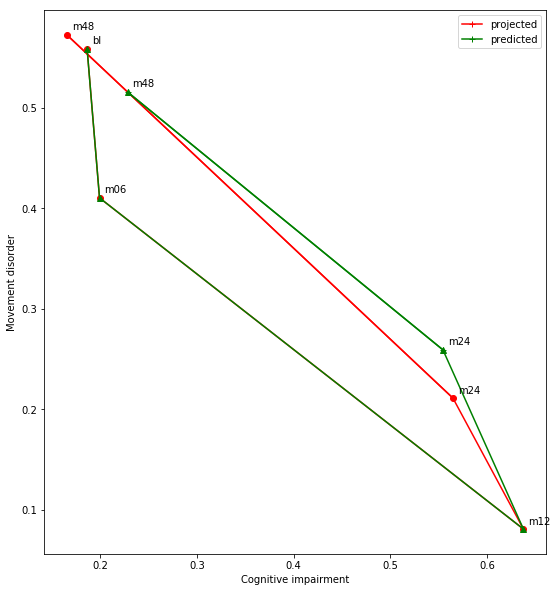

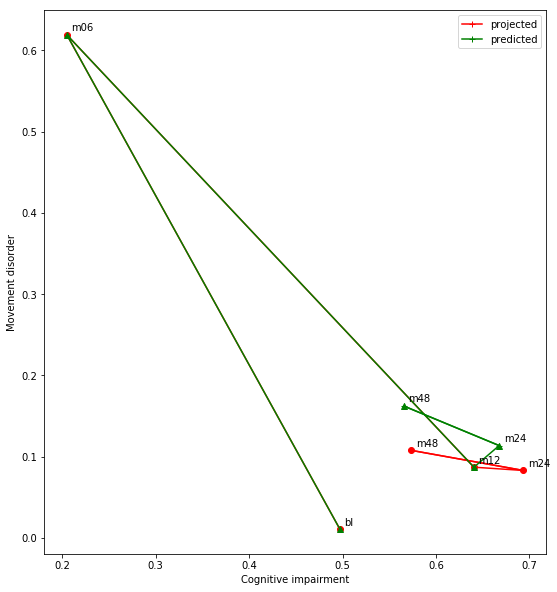

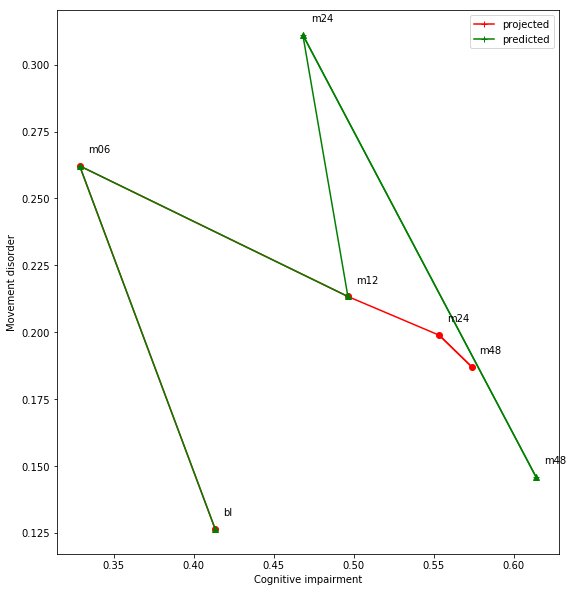

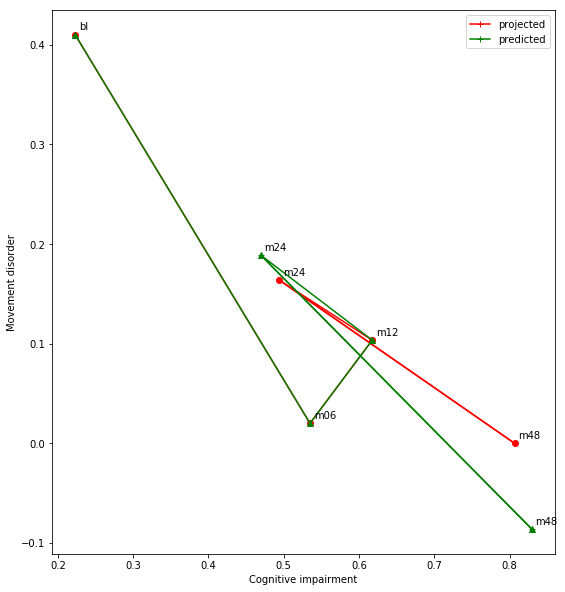

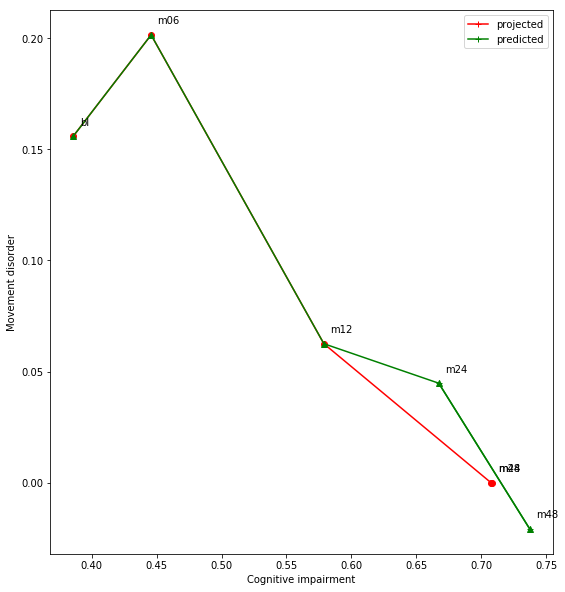

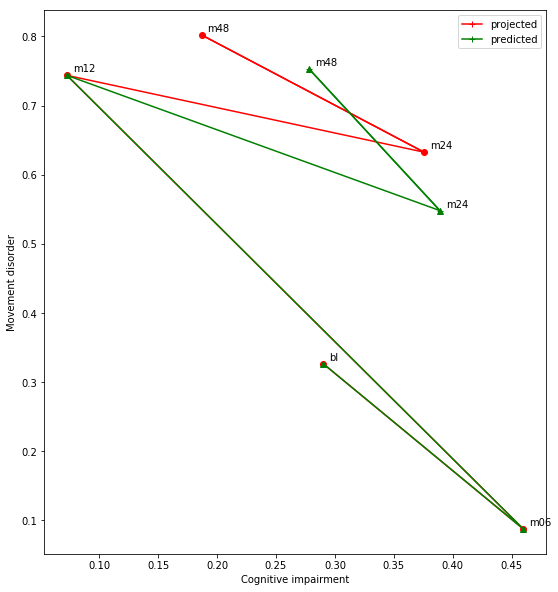

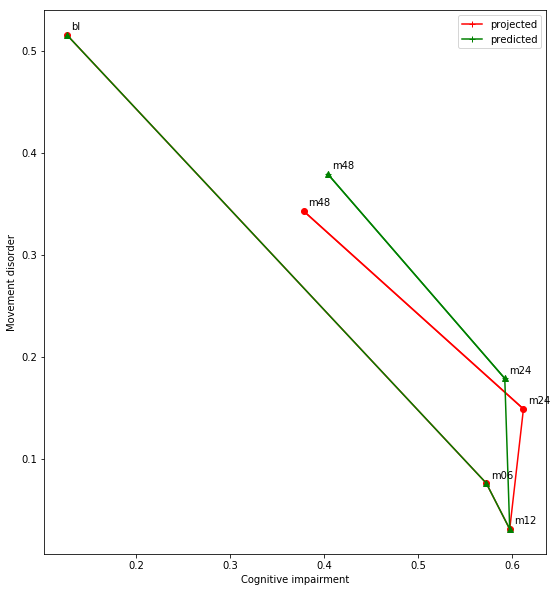

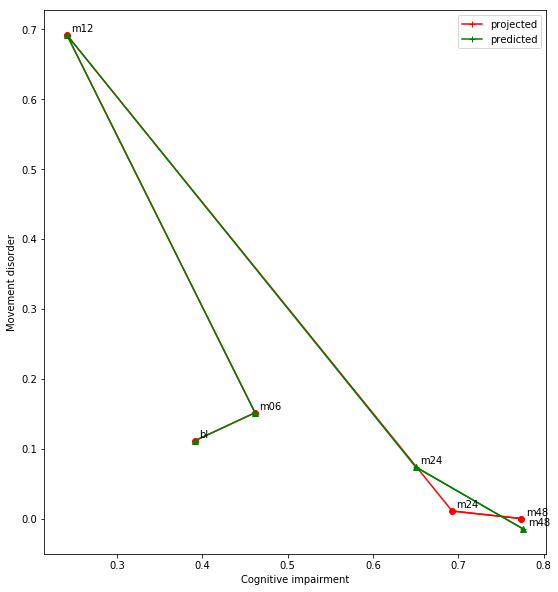

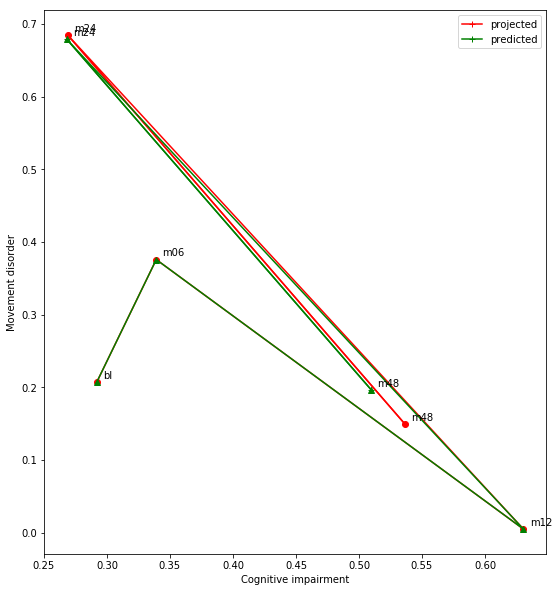

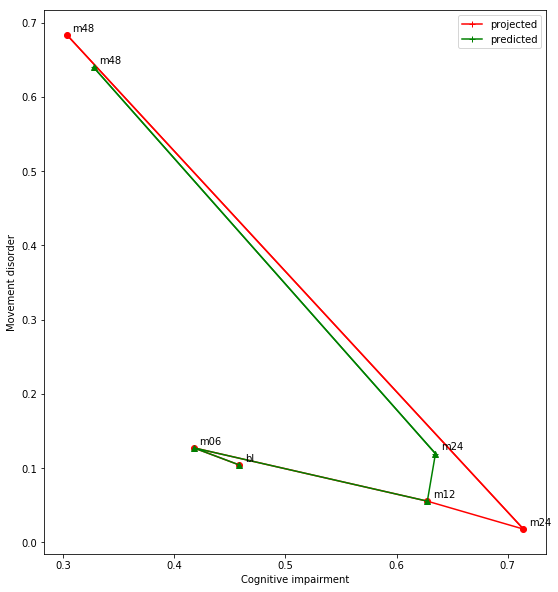

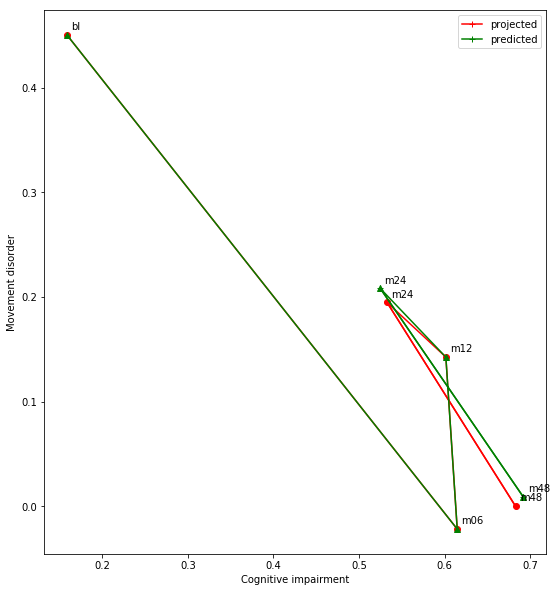

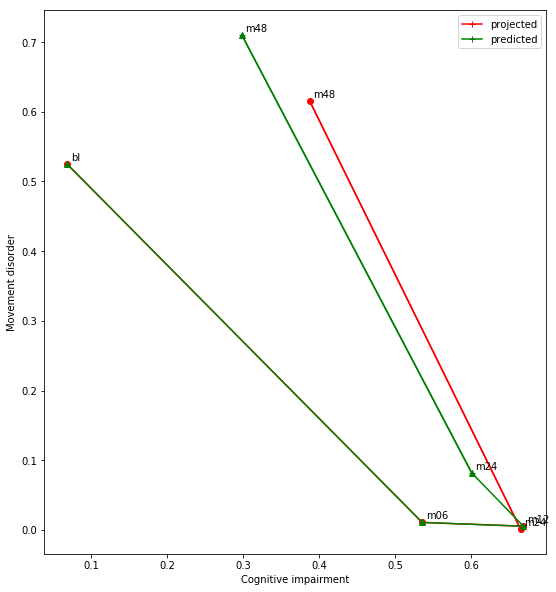

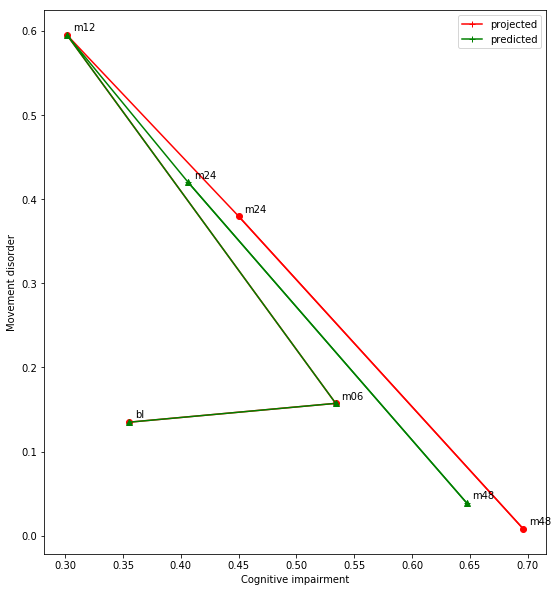

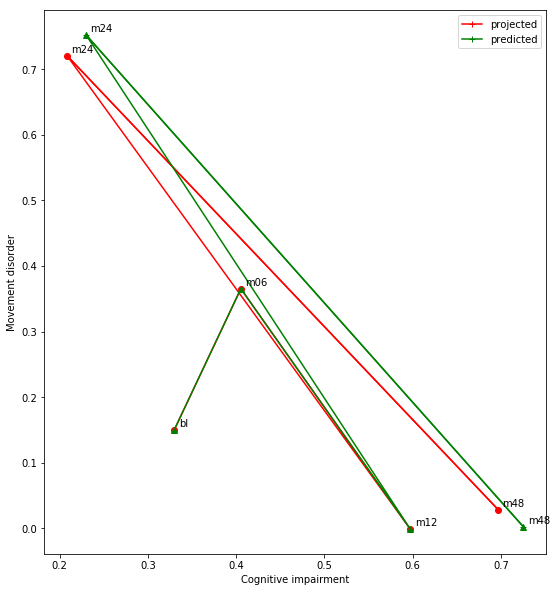

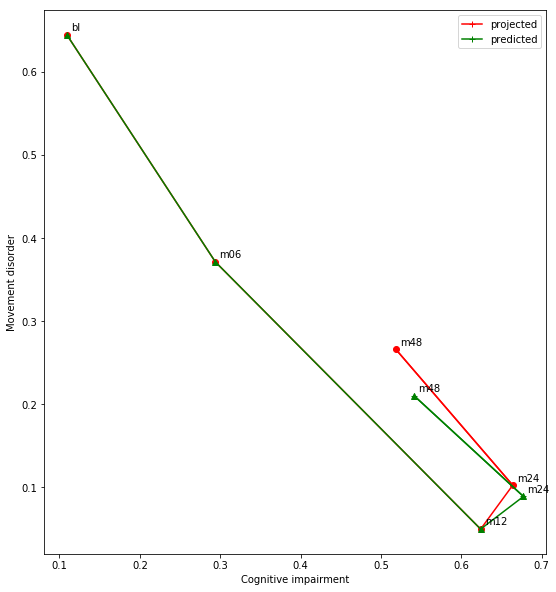

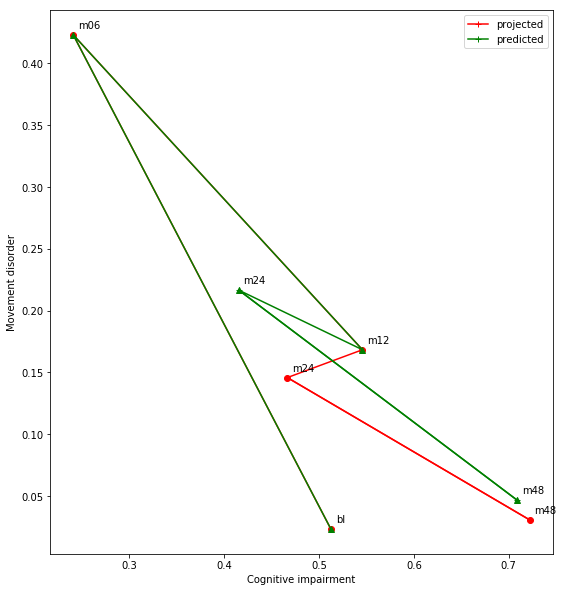

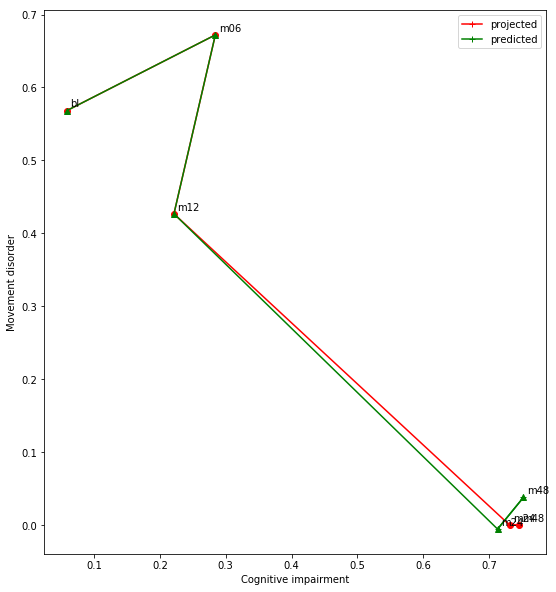

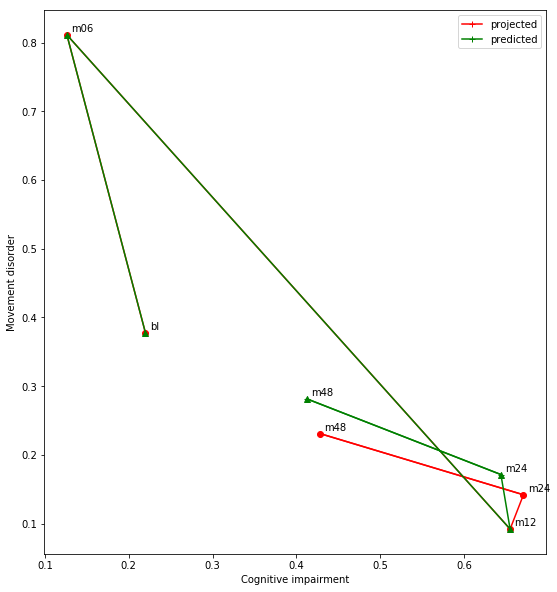

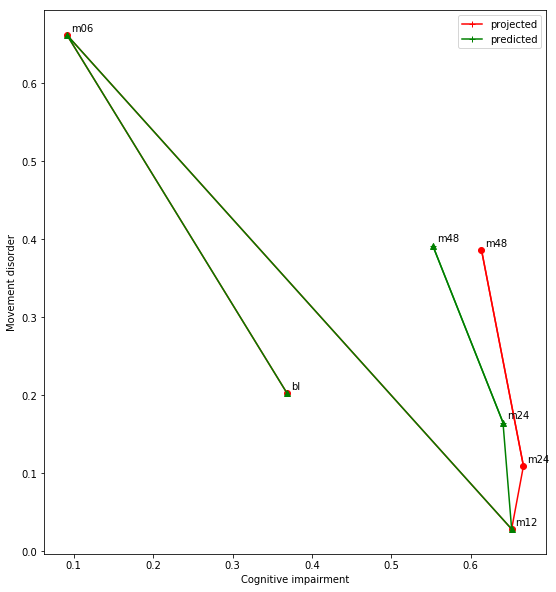

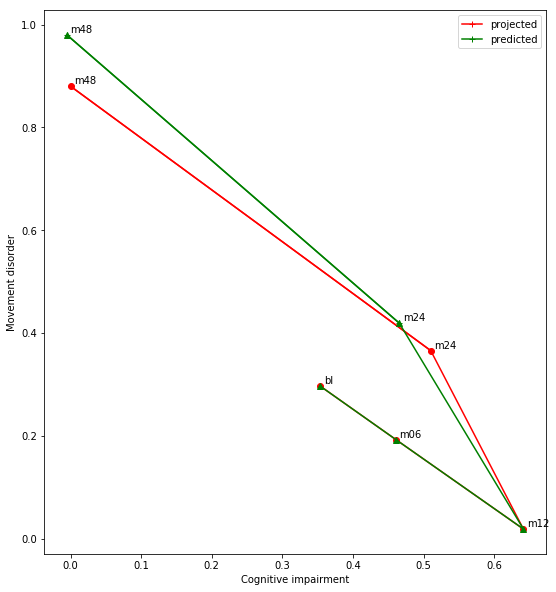

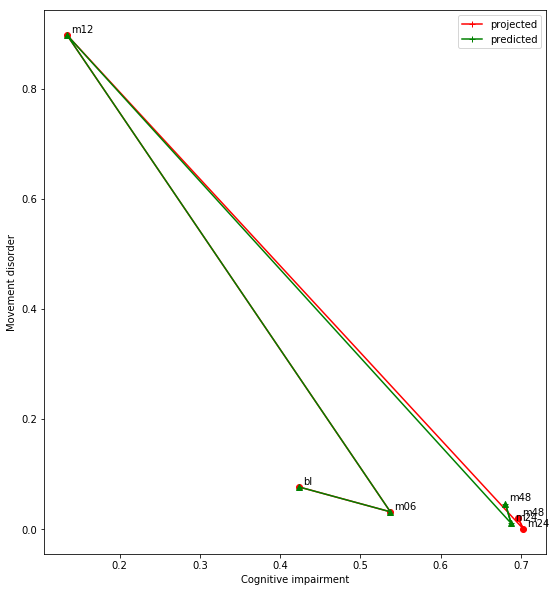

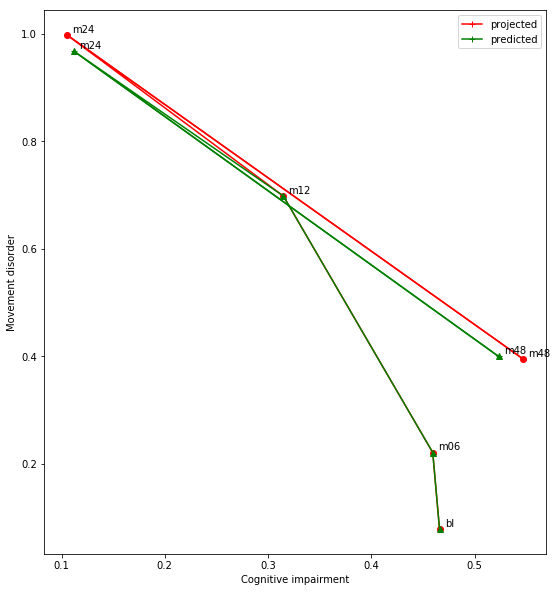

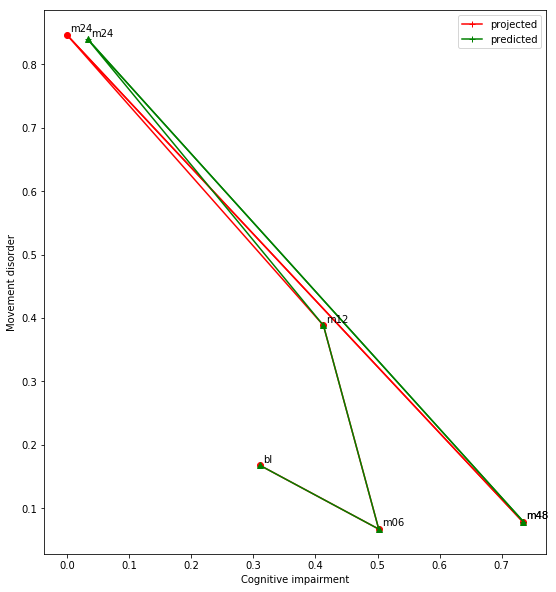

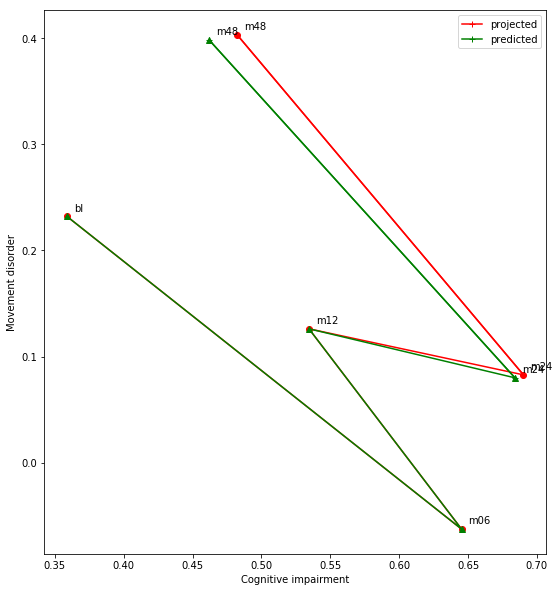

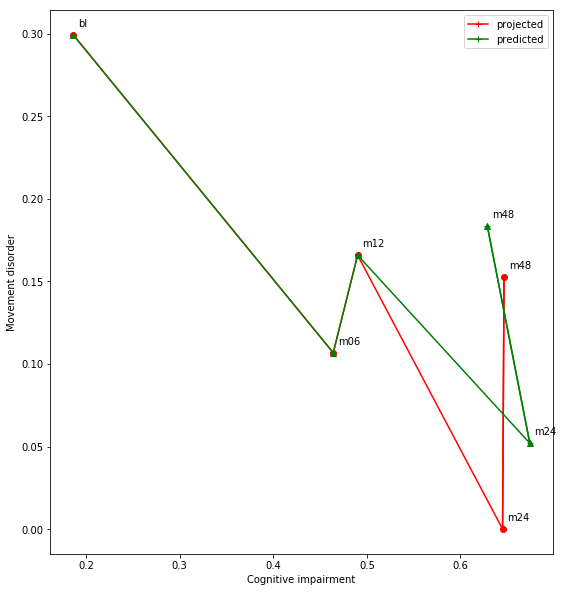

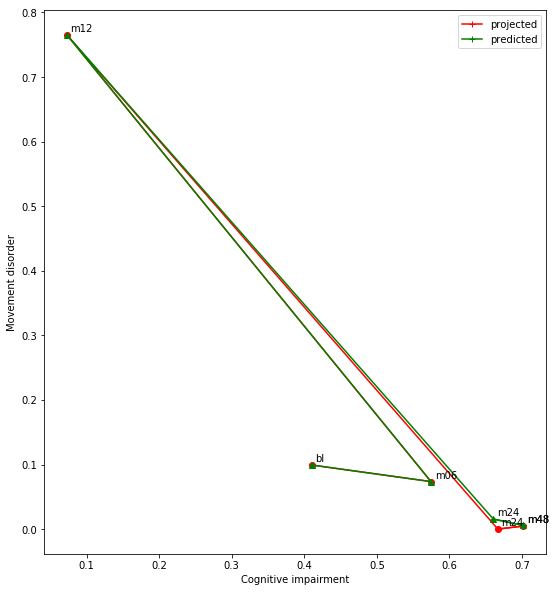

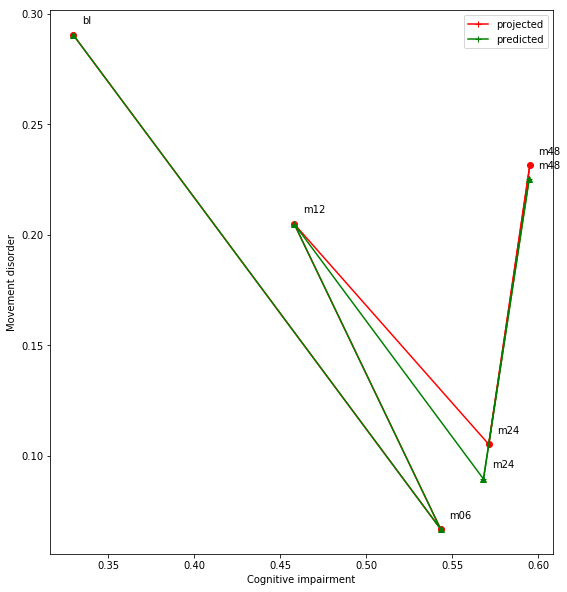

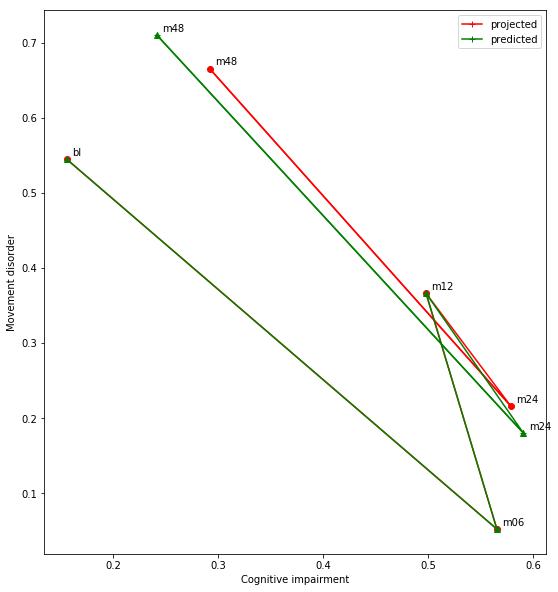

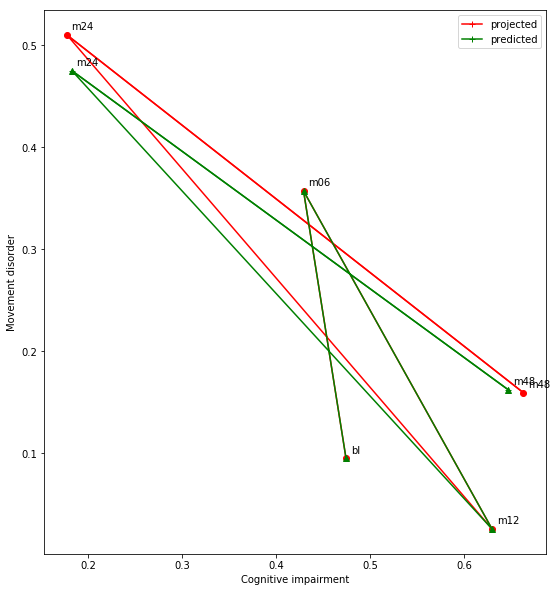

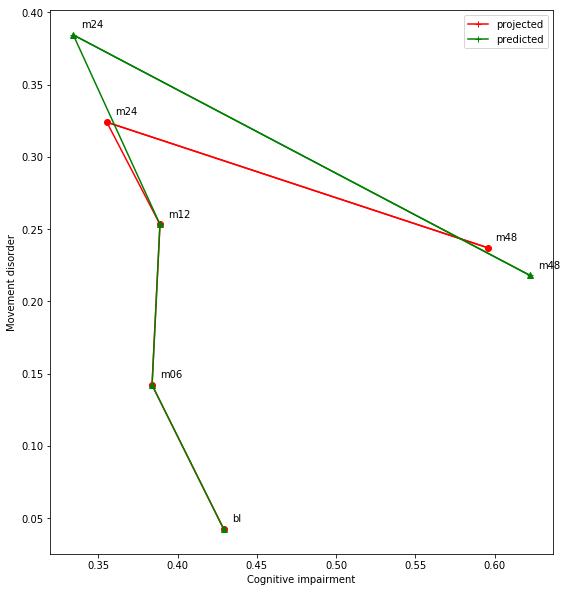

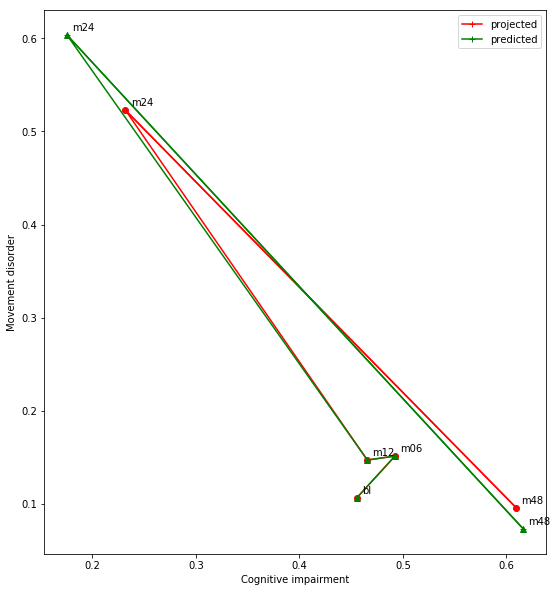

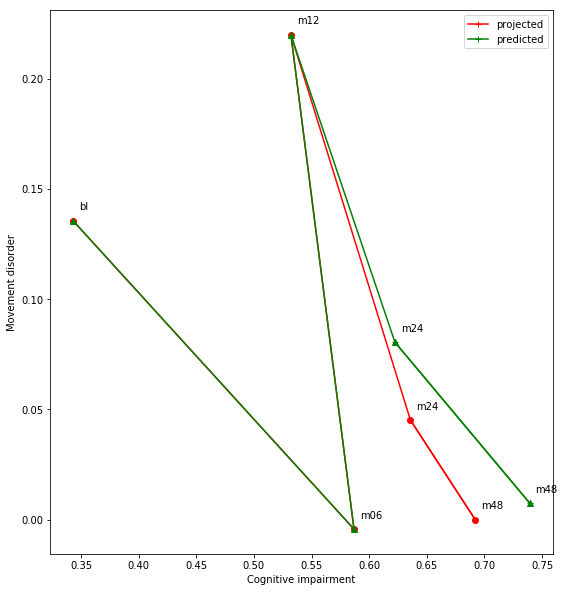

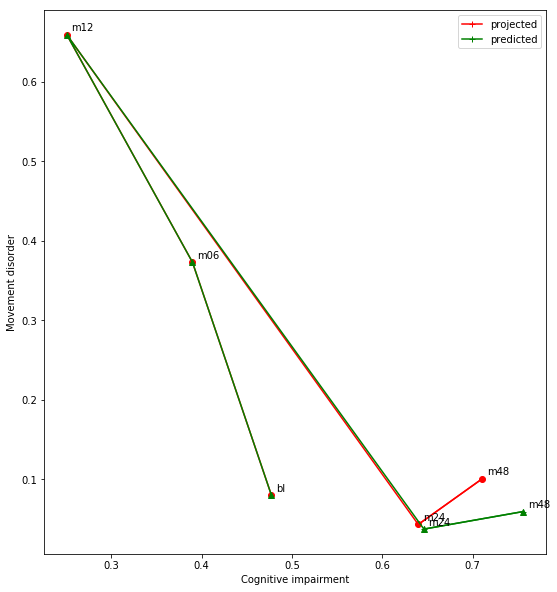

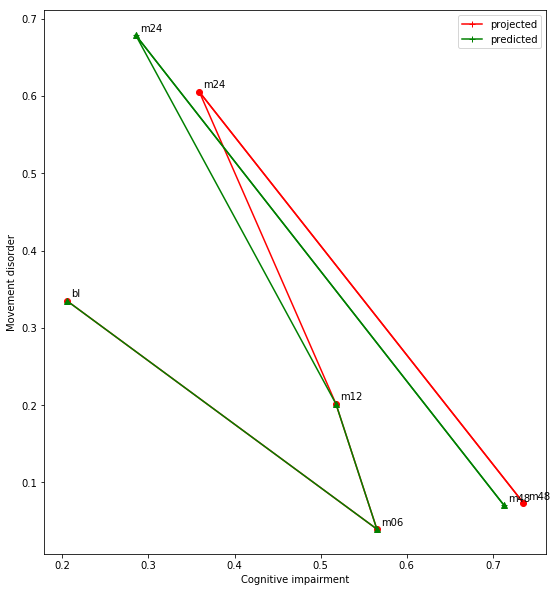

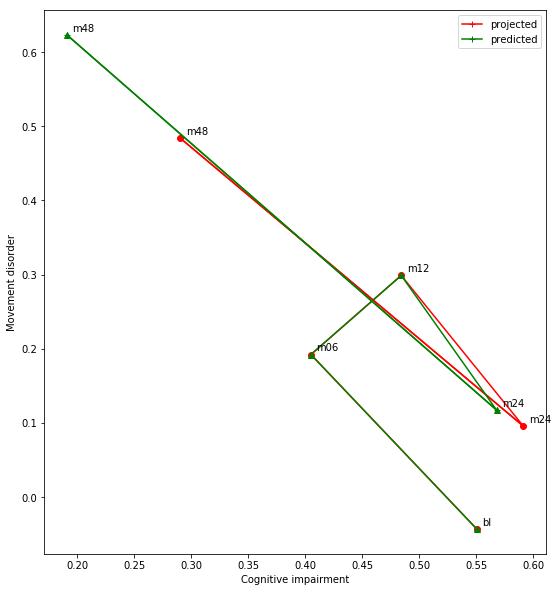

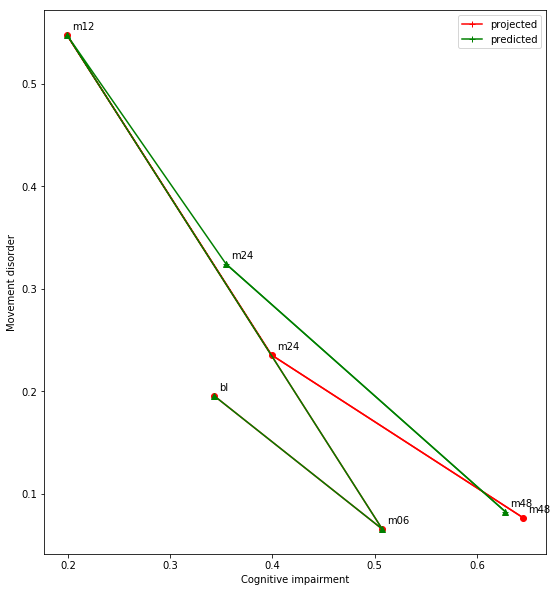

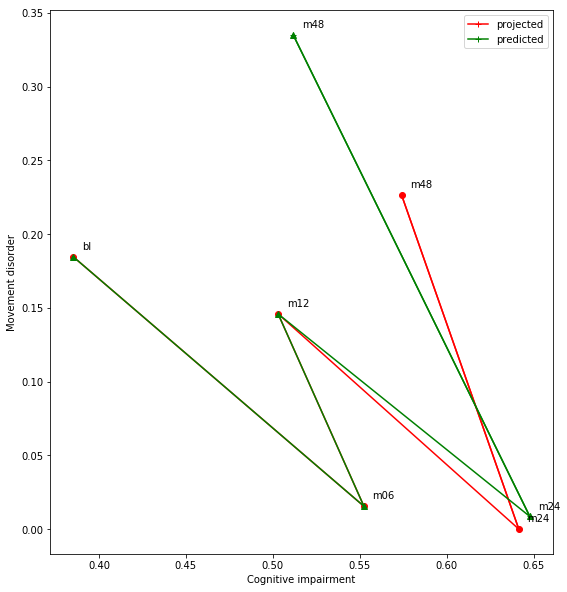

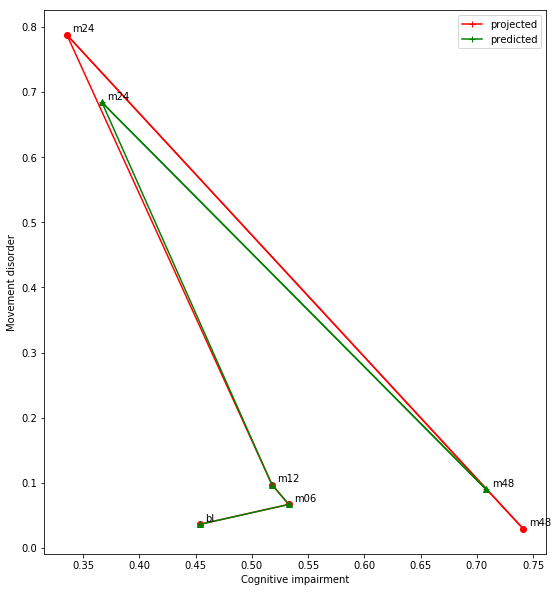

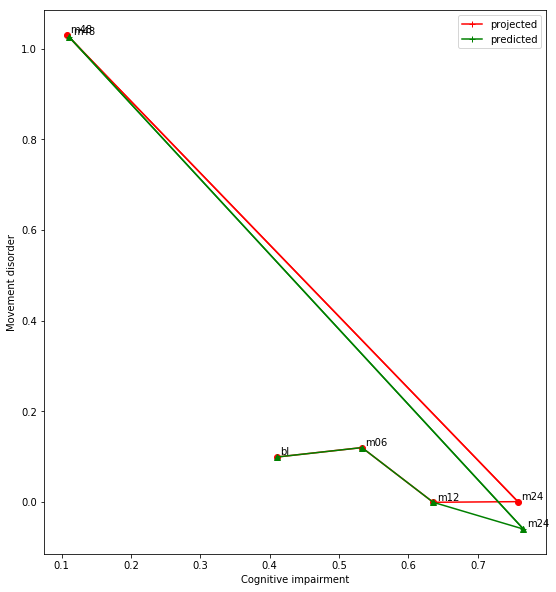

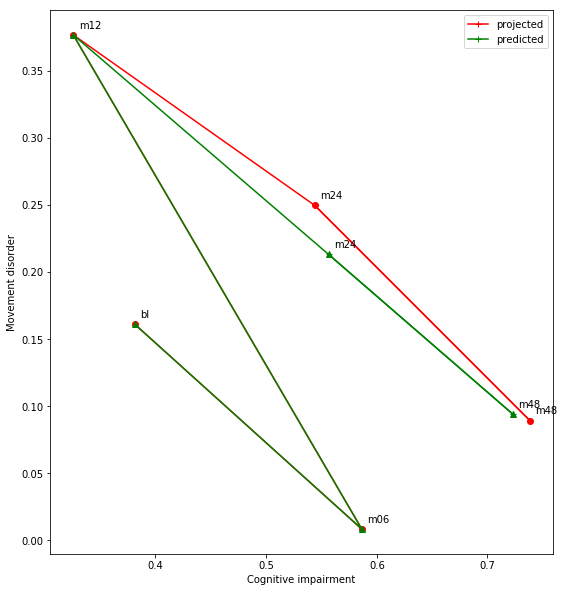

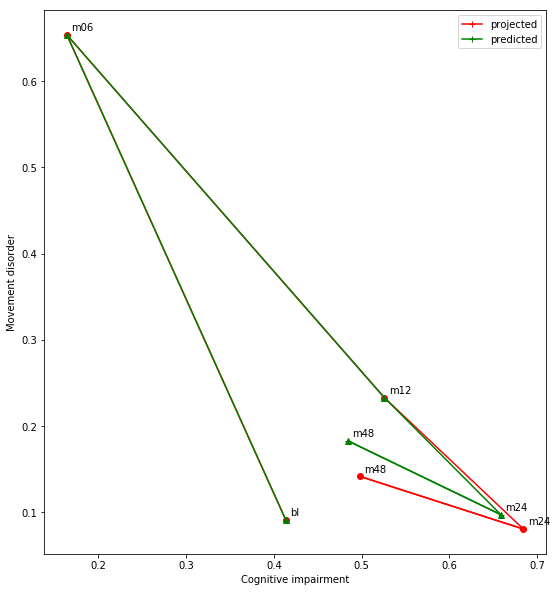

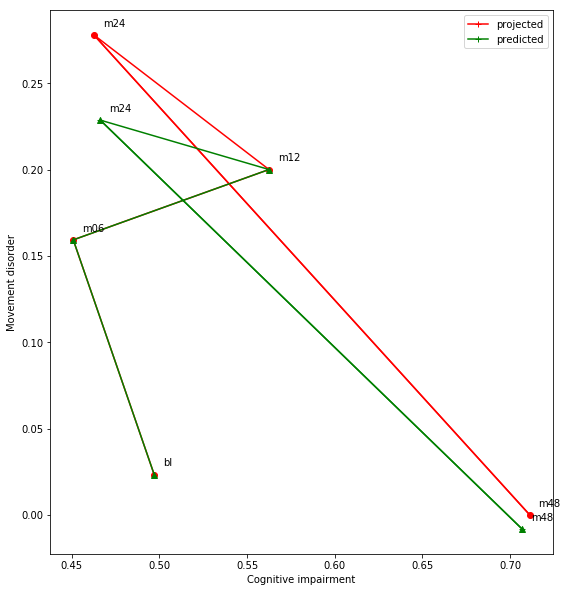

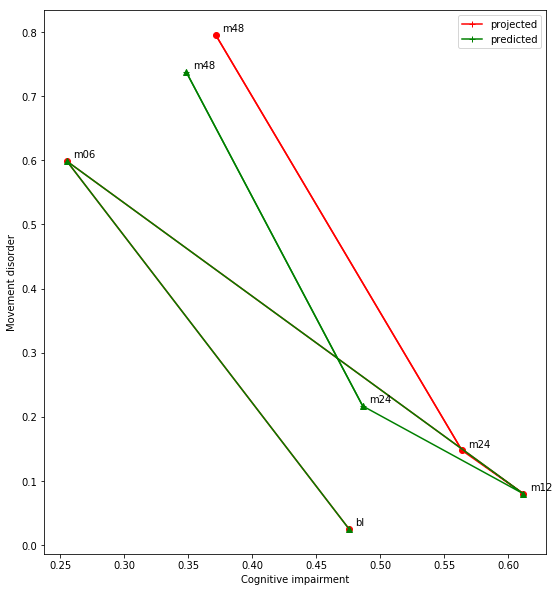

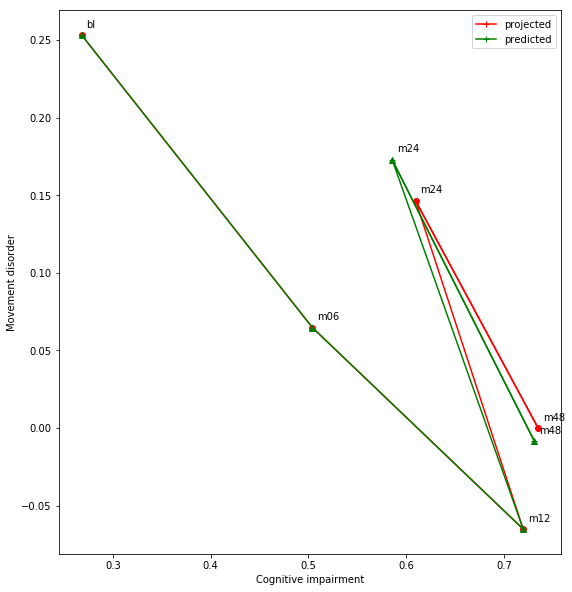

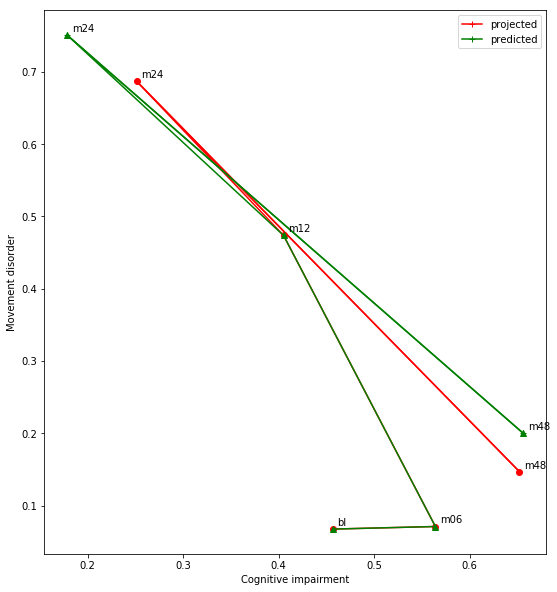

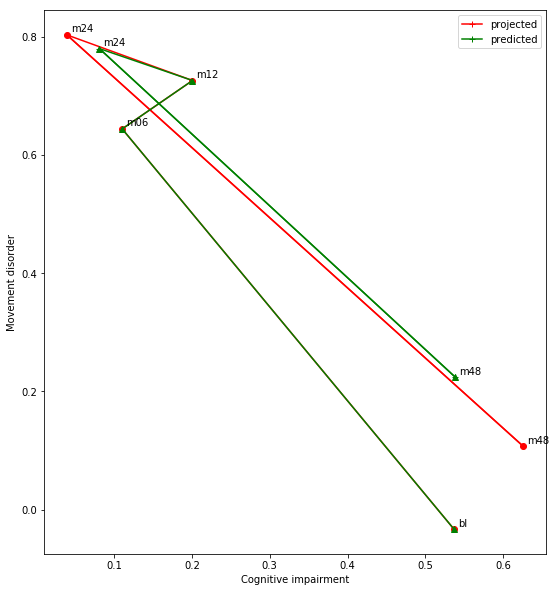

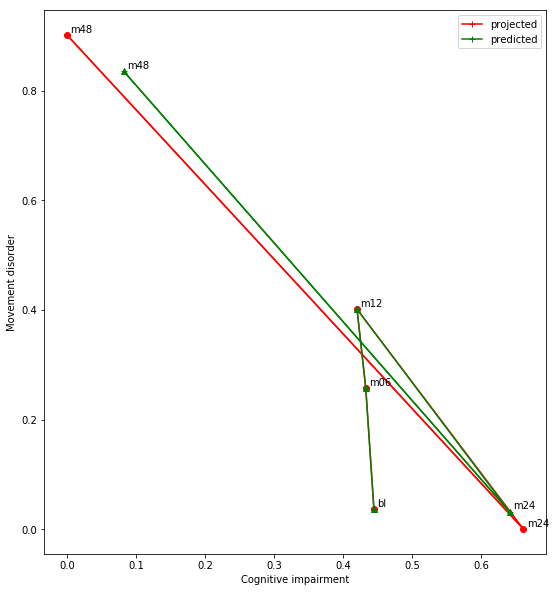

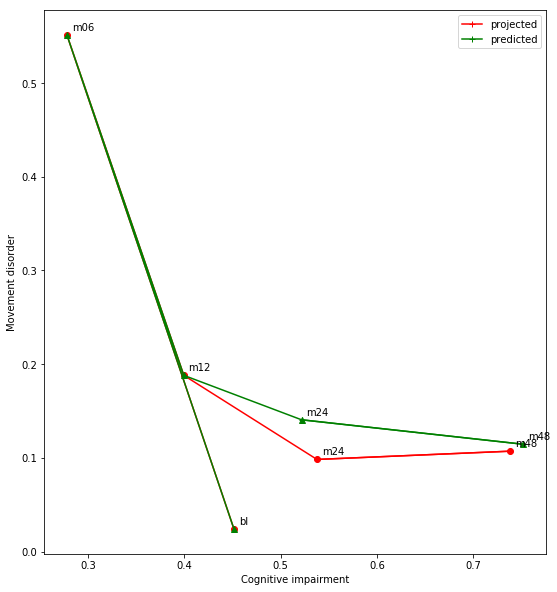

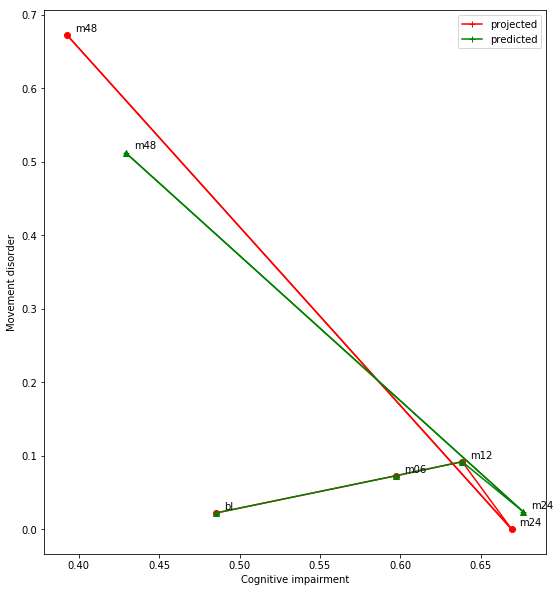

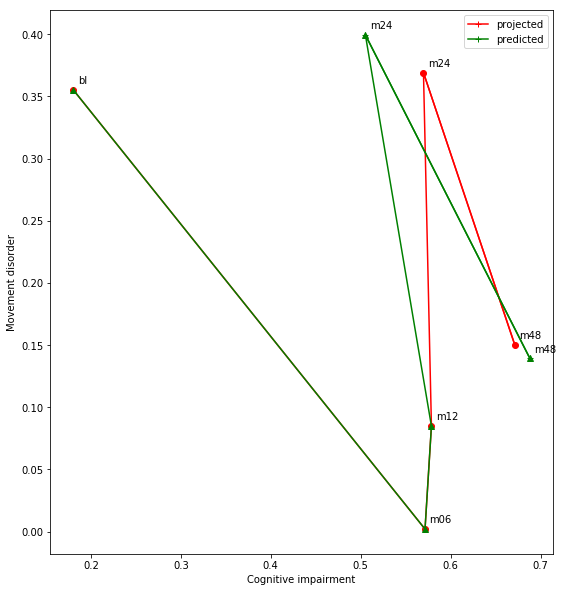

In [155]:
# Below function has 2 arguments
# 1) split - which split to visualize (0,1,2,3,4)
# 2) rid ( If not given it will visualize all rids in the split)
visualize_trajectory(3)